In [1]:
import pandas as pd
import numpy as np

import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from collections import Counter

import matplotlib.pyplot as plt

from IPython.display import clear_output

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  preprocessedDataPath = '/content/drive/Othercomputers/Компьютер/predicting-academic-performance 2.0/v2.0/preprocessed_data'
  dataPath = '/content/drive/Othercomputers/Компьютер/predicting-academic-performance 2.0/data'
else:
  preprocessedDataPath = 'preprocessed_data'
  dataPath = '../data'

In [4]:
df = pd.read_csv(os.path.join(preprocessedDataPath, 'final.csv'))

zakonchili_obuchenie_id = pd.read_csv(os.path.join(preprocessedDataPath,'zakonchili_obuchenie_id.csv'))
akademshiki_id = pd.read_csv(os.path.join(preprocessedDataPath,'akademshiki_id.csv'))
otchislennie_id = pd.read_csv(os.path.join(preprocessedDataPath,'otchislennie_id.csv'))

lst = pd.read_csv(os.path.join(preprocessedDataPath,'lichnost.csv'))

In [5]:
df.columns

Index(['LICHNOST_GUID', 'SEMESTR_ZAKRIT_DISC', 'BALL', 'VID_ATT_Зачет',
       'VID_ATT_Курсовая работа', 'VID_ATT_Курсовой проект', 'VID_ATT_Экзамен',
       'ISPRAV', 'ball_min', 'ball_min_sub', 'ball_max', 'ball_max_sub',
       'ball_mean', 'ball_mean_sub', 'ball_median', 'ball_median_sub',
       'percent_better_than_rest', 'prp', 'prp_vid_1', 'prp_vid_2',
       'prp_vid_3', 'prp_vid_4', 'prp_vid_5', 'min_prp', 'sub_min_prp',
       'max_prp', 'sub_max_prp', 'mean_prp', 'sub_mean_prp', 'median_prp',
       'sub_median_prp', 'DISC_CHASY', 'prp_to_aud_chasy_ratio',
       'prp_vid_1_to_aud_chasy_ratio', 'prp_vid_2_to_aud_chasy_ratio',
       'prp_vid_3_to_aud_chasy_ratio', 'prp_vid_4_to_aud_chasy_ratio',
       'prp_vid_5_to_aud_chasy_ratio'],
      dtype='object')

In [6]:
df = df.sort_values(by=['LICHNOST_GUID', 'SEMESTR_ZAKRIT_DISC'])

In [7]:
features = ['BALL', 'ISPRAV', \
            'VID_ATT_Зачет', 'VID_ATT_Курсовая работа', 'VID_ATT_Курсовой проект', 'VID_ATT_Экзамен', \
            'ball_min_sub', 'ball_max_sub', 'ball_mean_sub', 'ball_median_sub', 'percent_better_than_rest', \
            'sub_min_prp','sub_max_prp', 'sub_mean_prp','sub_median_prp', 'DISC_CHASY', 'prp_to_aud_chasy_ratio',
       'prp_vid_1_to_aud_chasy_ratio', 'prp_vid_2_to_aud_chasy_ratio',
       'prp_vid_3_to_aud_chasy_ratio', 'prp_vid_4_to_aud_chasy_ratio',
       'prp_vid_5_to_aud_chasy_ratio']

lst_features = ['POL_ID', 'AGE_POSTUPLENIYA',
       'TIP_FINANSIROVANIYA_Договорная', 'TIP_FINANSIROVANIYA_Целевой приём',
       'SLUSHATEL',]

In [8]:
df['SEMESTR_ZAKRIT_DISC'].value_counts()

SEMESTR_ZAKRIT_DISC
1.0    116297
2.0    108426
4.0    101369
5.0     98430
6.0     98072
3.0     97500
7.0     90630
8.0     76137
Name: count, dtype: int64

In [9]:
lst_dict = dict(lst.groupby('LICHNOST_GUID')[lst_features].min())

In [10]:
sc_df = StandardScaler()
sc_lst = StandardScaler()

sc_df.fit(df[features])
sc_lst.fit(lst[lst_features].to_numpy())

StandardScaler()

In [11]:
lst_features

['POL_ID',
 'AGE_POSTUPLENIYA',
 'TIP_FINANSIROVANIYA_Договорная',
 'TIP_FINANSIROVANIYA_Целевой приём',
 'SLUSHATEL']

In [12]:
final_matrix = []
max_len_data = 0

for lichnost_guid, lichnost_group_data in df.groupby('LICHNOST_GUID'):
    lichnost_matrix = []
    flag = False
    for semestr, semestr_group_data in lichnost_group_data.groupby('SEMESTR_ZAKRIT_DISC'):
        lst_scaled_data = []
        semestr_info = [int(lichnost_guid not in (zakonchili_obuchenie_id.to_numpy()))]
        
        for lst_feature in lst_features:
            if lichnost_guid in lst_dict[lst_feature]:
                lst_scaled_data.append(lst_dict[lst_feature][lichnost_guid])
            else:
                flag = True
        
        if flag:
            continue
        
        semestr_info.extend(lst_scaled_data)

        for subject in sc_df.transform(semestr_group_data[features]):
            semestr_info.extend(subject)

        max_len_data = max(max_len_data, len(semestr_info) - 1)
        lichnost_matrix.append(semestr_info)
    if lichnost_matrix:
        final_matrix.append(lichnost_matrix)

In [13]:
max_len_data


995

In [14]:
def collate_fn_with_padding(semestri_vseh, pad_id=0):
    max_count_semestrs = max(len(semestri_odnogo) for semestri_odnogo in semestri_vseh)
    new_batch = []
    for semestri_odnogo in semestri_vseh:
        new_semestri_odnogo = []
        for semestr in semestri_odnogo:
            semestr += [pad_id] * (max_len_data + 1 - len(semestr))
            new_semestri_odnogo.append(semestr)

        for _ in range(max_count_semestrs - len(semestri_odnogo)):
            new_semestri_odnogo.append([semestri_odnogo[0][0]] + ([pad_id] * (max_len_data)))

        new_batch.append(new_semestri_odnogo)

    float_tensor = torch.FloatTensor(new_batch).to(device)

    new_batch = {
        'input_ids': float_tensor[:,:, 1:],
        'target_ids': float_tensor[:,:, 0]
    }

    return new_batch


In [15]:
class OcenkaDataset:
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx: int) -> list[int]:
        return self.data[idx]

    def __len__(self) -> int:
        return len(self.data)

In [16]:
train_ocenka, eval_ocenka = train_test_split(final_matrix, test_size=0.2)
# eval_ocenka, test_ocenka = train_test_split(eval_ocenka, test_size=0.5)

train_dataset = OcenkaDataset(train_ocenka)
eval_dataset = OcenkaDataset(eval_ocenka)
# test_dataset = OcenkaDataset(test_ocenka)

batch_size = 1

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

# test_dataloader = DataLoader(
#     test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [17]:
class OtchislenieModel_GRU(nn.Module): # Базовая модель
    def __init__(self, hidden_dim, input_size, num_classes):
        super().__init__()
        self.input_linear = nn.Linear(input_size, hidden_dim)
        self.non_lin = nn.Tanh()
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.input_linear(x)
        x = self.non_lin(x)
        x, _ = self.rnn(x)
        x = self.non_lin(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.non_lin(x)
        x = self.projection(x)
        x = self.non_lin(x)
        x = self.sigmoid(x)

        return x

class OtchislenieModel_LSTM(nn.Module): # Базовая модель
    def __init__(self, hidden_dim, input_size, num_classes):
        super().__init__()
        self.input_linear = nn.Linear(input_size, hidden_dim)
        self.non_lin = nn.Tanh()
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.input_linear(x)
        x = self.non_lin(x)
        x, _ = self.rnn(x)
        x = self.non_lin(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.non_lin(x)
        x = self.projection(x)
        x = self.non_lin(x)
        x = self.sigmoid(x)

        return x

class OtchislenieModel(nn.Module): # Базовая модель
    def __init__(self, hidden_dim, input_size, num_classes):
        super().__init__()
        self.input_linear = nn.Linear(input_size, hidden_dim)
        self.non_lin = nn.Tanh()
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.input_linear(x)
        x = self.non_lin(x)
        x, _ = self.rnn(x)
        x = self.non_lin(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.non_lin(x)
        x = self.projection(x)
        x = self.non_lin(x)
        x = self.sigmoid(x)

        return x
        
class OtchislenieModel_CustomStructure(nn.Module): # Кастомная модель
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.input_linear = nn.Linear(input_size, 512)
        self.non_lin = nn.Tanh()
        self.rnn = nn.RNN(512, 256, batch_first=True)
        self.non_lin = nn.Tanh()
        self.linear = nn.Linear(256, 128)
        self.dropout = nn.Dropout(p=0.1)
        self.non_lin = nn.Tanh()
        self.projection = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.input_linear(x)
        x = self.non_lin(x)
        x, _ = self.rnn(x)
        x = self.non_lin(x)
        x = self.linear(x)
        x = self.dropout(x)
        x = self.non_lin(x)
        x = self.projection(x)
        x = self.sigmoid(x)

        return x

class OtchislenieModel_GRU_CustomStructure(nn.Module): # Кастомная модель
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.input_linear = nn.Linear(input_size, 512)
        self.non_lin = nn.Tanh()
        self.rnn = nn.GRU(512, 256, batch_first=True)
        self.non_lin = nn.Tanh()
        self.linear = nn.Linear(256, 128)
        self.dropout = nn.Dropout(p=0.1)
        self.non_lin = nn.Tanh()
        self.projection = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.input_linear(x)
        x = self.non_lin(x)
        x, _ = self.rnn(x)
        x = self.non_lin(x)
        x = self.linear(x)
        x = self.dropout(x)
        x = self.non_lin(x)
        x = self.projection(x)
        x = self.sigmoid(x)

        return x

class OtchislenieModel_LSTM_CustomStructure(nn.Module): # Кастомная модель
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.input_linear = nn.Linear(input_size, 512)
        self.non_lin = nn.Tanh()
        self.rnn = nn.LSTM(512, 256, batch_first=True)
        self.non_lin = nn.Tanh()
        self.linear = nn.Linear(256, 128)
        self.dropout = nn.Dropout(p=0.1)
        self.non_lin = nn.Tanh()
        self.projection = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.input_linear(x)
        x = self.non_lin(x)
        x, _ = self.rnn(x)
        x = self.non_lin(x)
        x = self.linear(x)
        x = self.dropout(x)
        x = self.non_lin(x)
        x = self.projection(x)
        x = self.sigmoid(x)

        return x

In [18]:
def show_loss_graph(losses): 
    epochs = np.arange(1, len(losses)+1)

    fig, axs = plt.subplots(1, 1, figsize=(12, 5))

    axs.plot(epochs, losses, color='blue')
    axs.set_title('Losses')
    axs.set_xlabel('Epoch')
    
    plt.tight_layout()
    plt.show()

In [19]:
def show_f1_graphs(f1s): 
    epochs = np.arange(1, len(f1s)+1)

    fig, axs = plt.subplots(2, 4, figsize=(40, 20))

    for n_semestr in range(8):
        axs[n_semestr//4][n_semestr%4].plot(epochs, np.array(f1s).T[n_semestr], color='red')
        axs[n_semestr//4][n_semestr%4].set_title(f'F1 Semestr: {n_semestr+1}')
        axs[n_semestr//4][n_semestr%4].set_xlabel('Epoch')

    plt.tight_layout()
    plt.show()

In [20]:
def show_auc_graphs(y_trues, y_preds): 
    fig, axs = plt.subplots(2, 4, figsize=(40, 20))

    for n_semestr in range(8):
        indexes = np.where(~np.isnan(y_preds[n_semestr]))[0]
        
        fpr, tpr, thresholds = roc_curve(np.array(y_trues)[indexes], y_preds[n_semestr][indexes])
        roc_auc = auc(fpr, tpr)

        axs[n_semestr//4][n_semestr%4].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        axs[n_semestr//4][n_semestr%4].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs[n_semestr//4][n_semestr%4].set_xlim([0.0, 1.0])
        axs[n_semestr//4][n_semestr%4].set_ylim([0.0, 1.05])
        axs[n_semestr//4][n_semestr%4].set_xlabel('False Positive Rate')
        axs[n_semestr//4][n_semestr%4].set_ylabel('True Positive Rate')
        axs[n_semestr//4][n_semestr%4].set_title(f'Receiver Operating Characteristic (ROC) Semestr {n_semestr+1}')

    plt.tight_layout()
    plt.show()

In [21]:
def evaluate(model, dataloader):
    model.eval()
    y_preds = np.empty((12,1))
    y_trues = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f'Testing'):
            logits = torch.round(model(batch['input_ids']).cpu().flatten()).reshape(-1,1)
            padded_logits = np.pad(logits, ((0, 12 - len(logits)), (0, 0)), mode='constant', constant_values=np.nan)
            y_true = batch['target_ids'].cpu().flatten()
            y_preds = np.column_stack((y_preds, padded_logits))

            y_trues.append(y_true[0])

    return y_trues, y_preds[:, 1:]

In [22]:
def get_scores(y_trues, y_preds):
    f1_each_semestr = []
    roc_each_semestr = []

    for n_semestr in range(8):
        indexes = np.where(~np.isnan(y_preds[n_semestr]))[0]
        f1_each_semestr.append(f1_score(np.array(y_trues)[indexes], y_preds[n_semestr][indexes]))
        roc_each_semestr.append(roc_auc_score(np.array(y_trues)[indexes], y_preds[n_semestr][indexes]))

    return f1_each_semestr, roc_each_semestr


In [23]:
def print_classifications_reports(y_trues, y_preds):
    for n_semestr in range(8):
        indexes = np.where(~np.isnan(y_preds[n_semestr]))[0]
        print(f'Семестр {n_semestr+1}')
        print(classification_report(np.array(y_trues)[indexes], y_preds[n_semestr][indexes]))

In [24]:
def train_model(model, optimizer, criterion, num_epoch=25):
    losses = []
    f1s = []
    rocs = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch+1}'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten()
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))

        y_trues, y_preds = evaluate(model, eval_dataloader)

        f1_each_semestr, roc_each_semestr = get_scores(y_trues, y_preds)

        f1s.append(f1_each_semestr)
        rocs.append(roc_each_semestr)

        clear_output(wait=True)

        if np.mean(np.array(f1_each_semestr)) >= np.max(np.mean(np.array(f1s), axis=1)):
            best_y_true = y_trues
            best_y_pred = y_preds
            
        print(f'Min Loss = {min(losses)}')
        print(f'Curr F1 = {np.array(f1s).T[:, -1]}')
        print(f'Max F1 = {np.max(np.array(f1s).T, axis=1)}') 
        print(f'Curr AUC_ROC = {np.array(rocs).T[:, -1]}')
        print(f'Max AUC_ROC = {np.max(np.array(rocs).T, axis=1)}')

        print_classifications_reports(best_y_true, best_y_pred)        
        show_auc_graphs(best_y_true, best_y_pred)
        show_f1_graphs(f1s)

    return model

Vanilla RNN Base Structure

Min Loss = 0.44745866883567653
Curr F1 = [0.73694581 0.75934803 0.7014218  0.63420724 0.65434381 0.59638554
 0.6359447  0.6       ]
Max F1 = [0.74872912 0.75934803 0.71742543 0.66274971 0.69565217 0.67317073
 0.7027027  0.675     ]
Curr AUC_ROC = [0.73122758 0.79928118 0.78162201 0.75010867 0.76484456 0.73310759
 0.75910846 0.75767848]
Max AUC_ROC = [0.76050932 0.79928118 0.79539359 0.77578903 0.8116183  0.81586687
 0.84831027 0.85135381]
Семестр 1
              precision    recall  f1-score   support

         0.0       0.81      0.73      0.77      1555
         1.0       0.71      0.79      0.75      1299

    accuracy                           0.76      2854
   macro avg       0.76      0.76      0.76      2854
weighted avg       0.76      0.76      0.76      2854

Семестр 2
              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84      1555
         1.0       0.76      0.75      0.76      1036

    accuracy                           0.81   

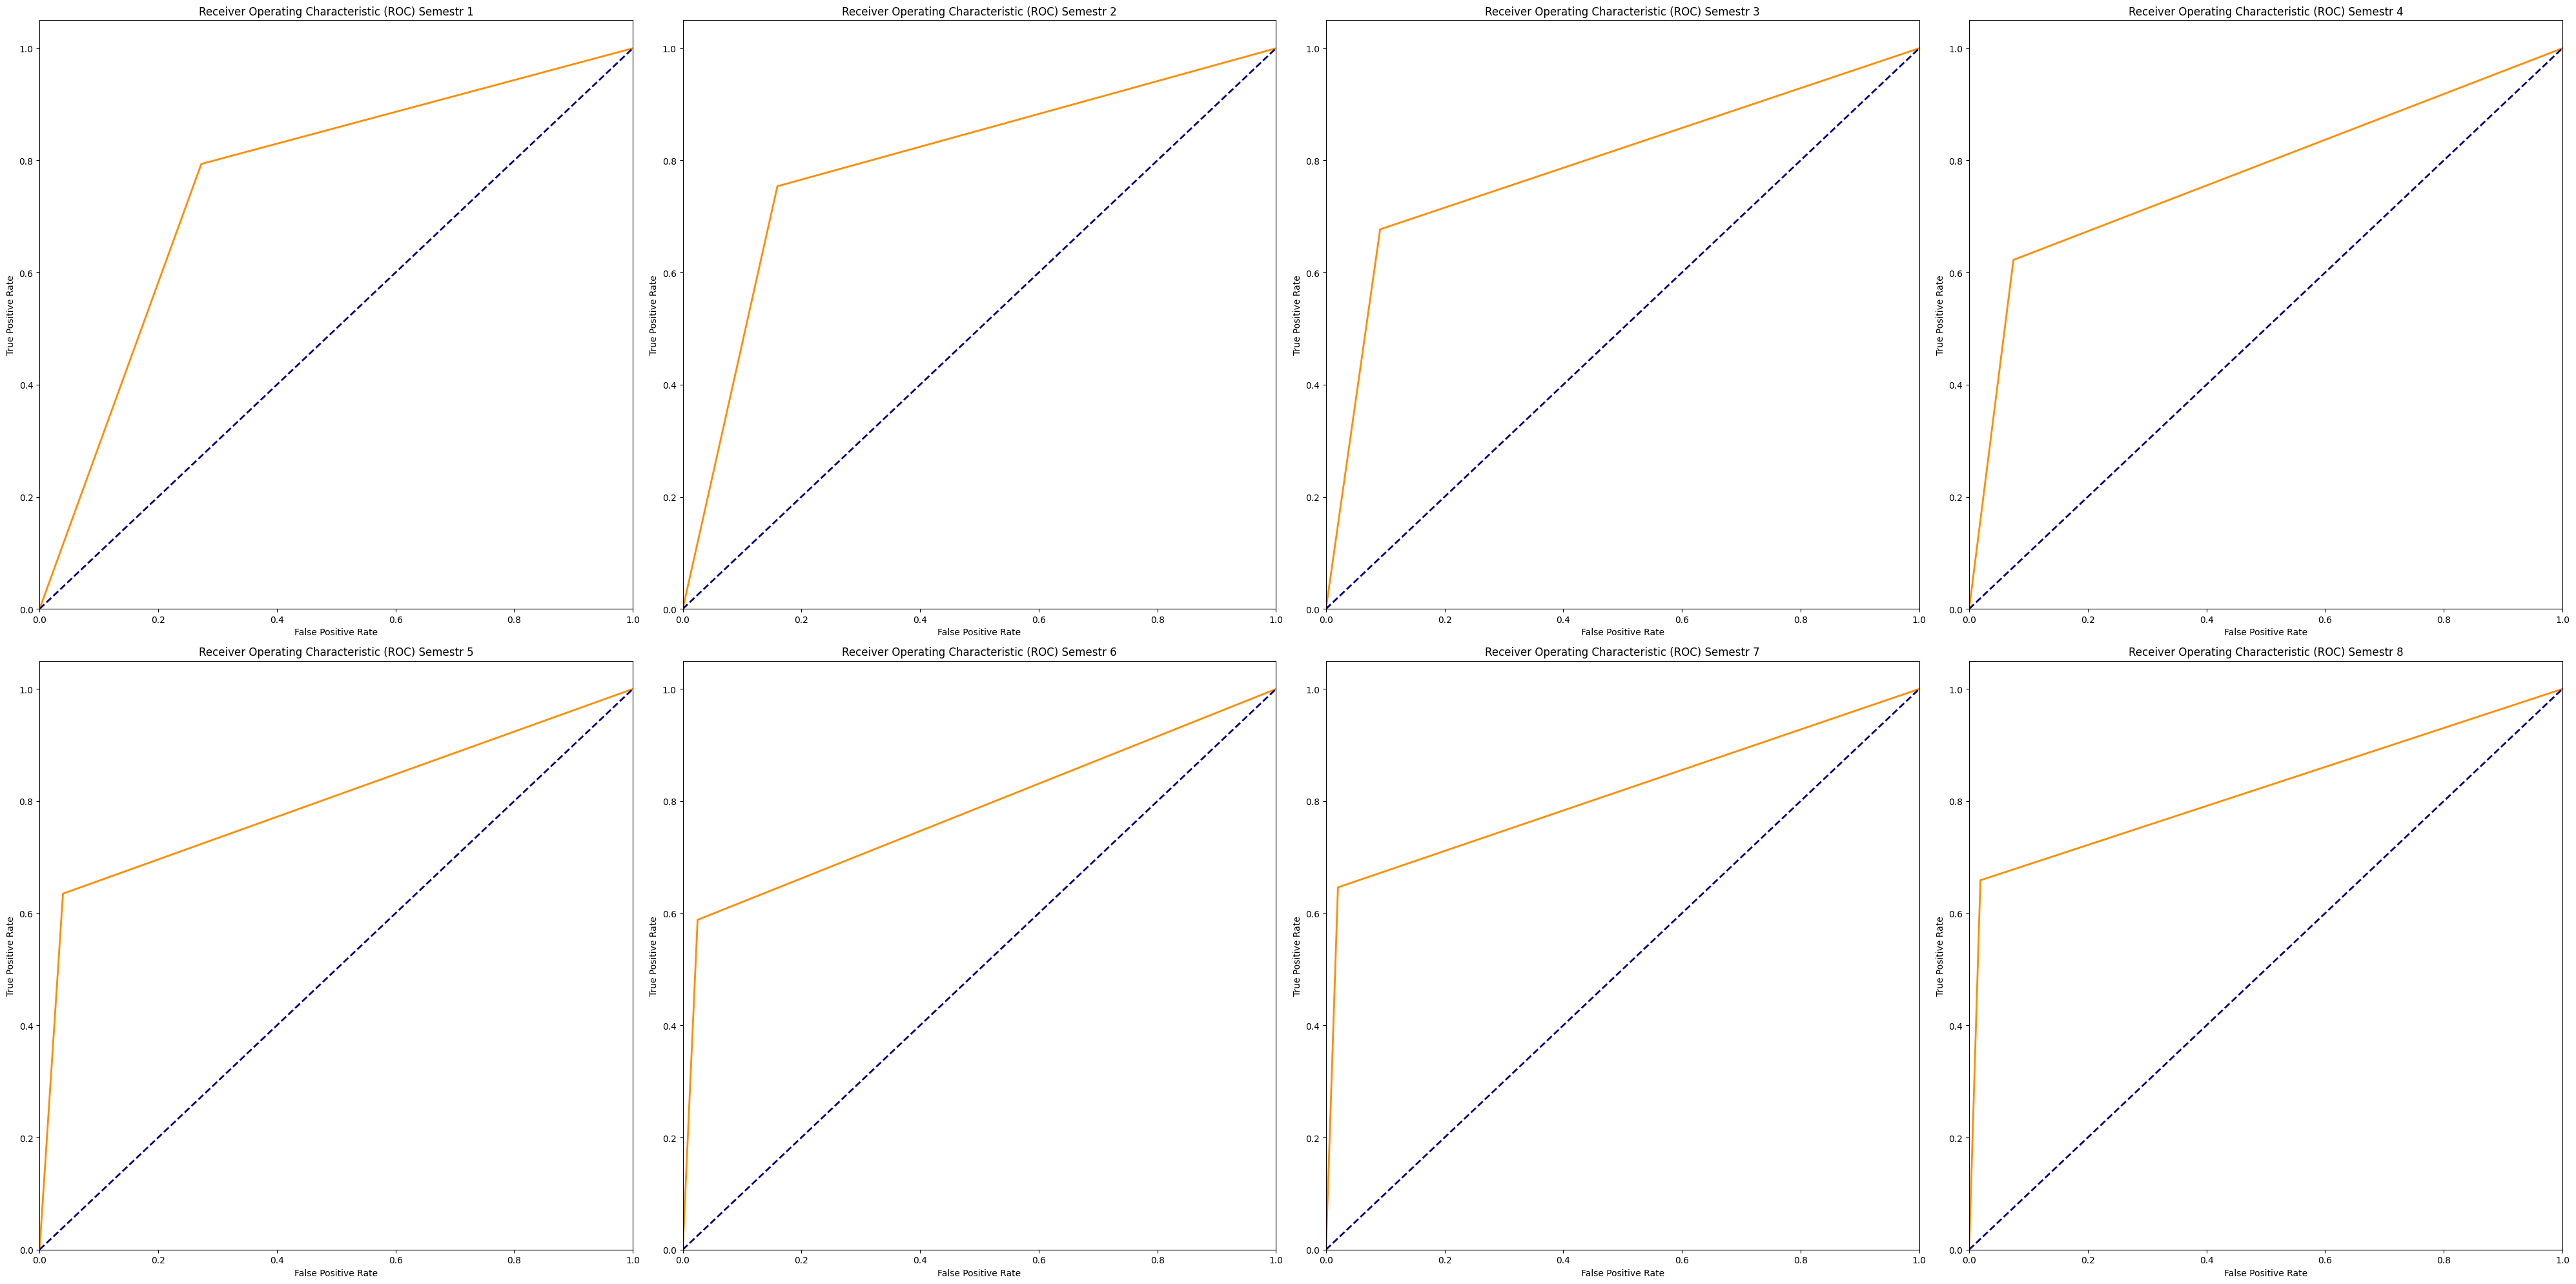

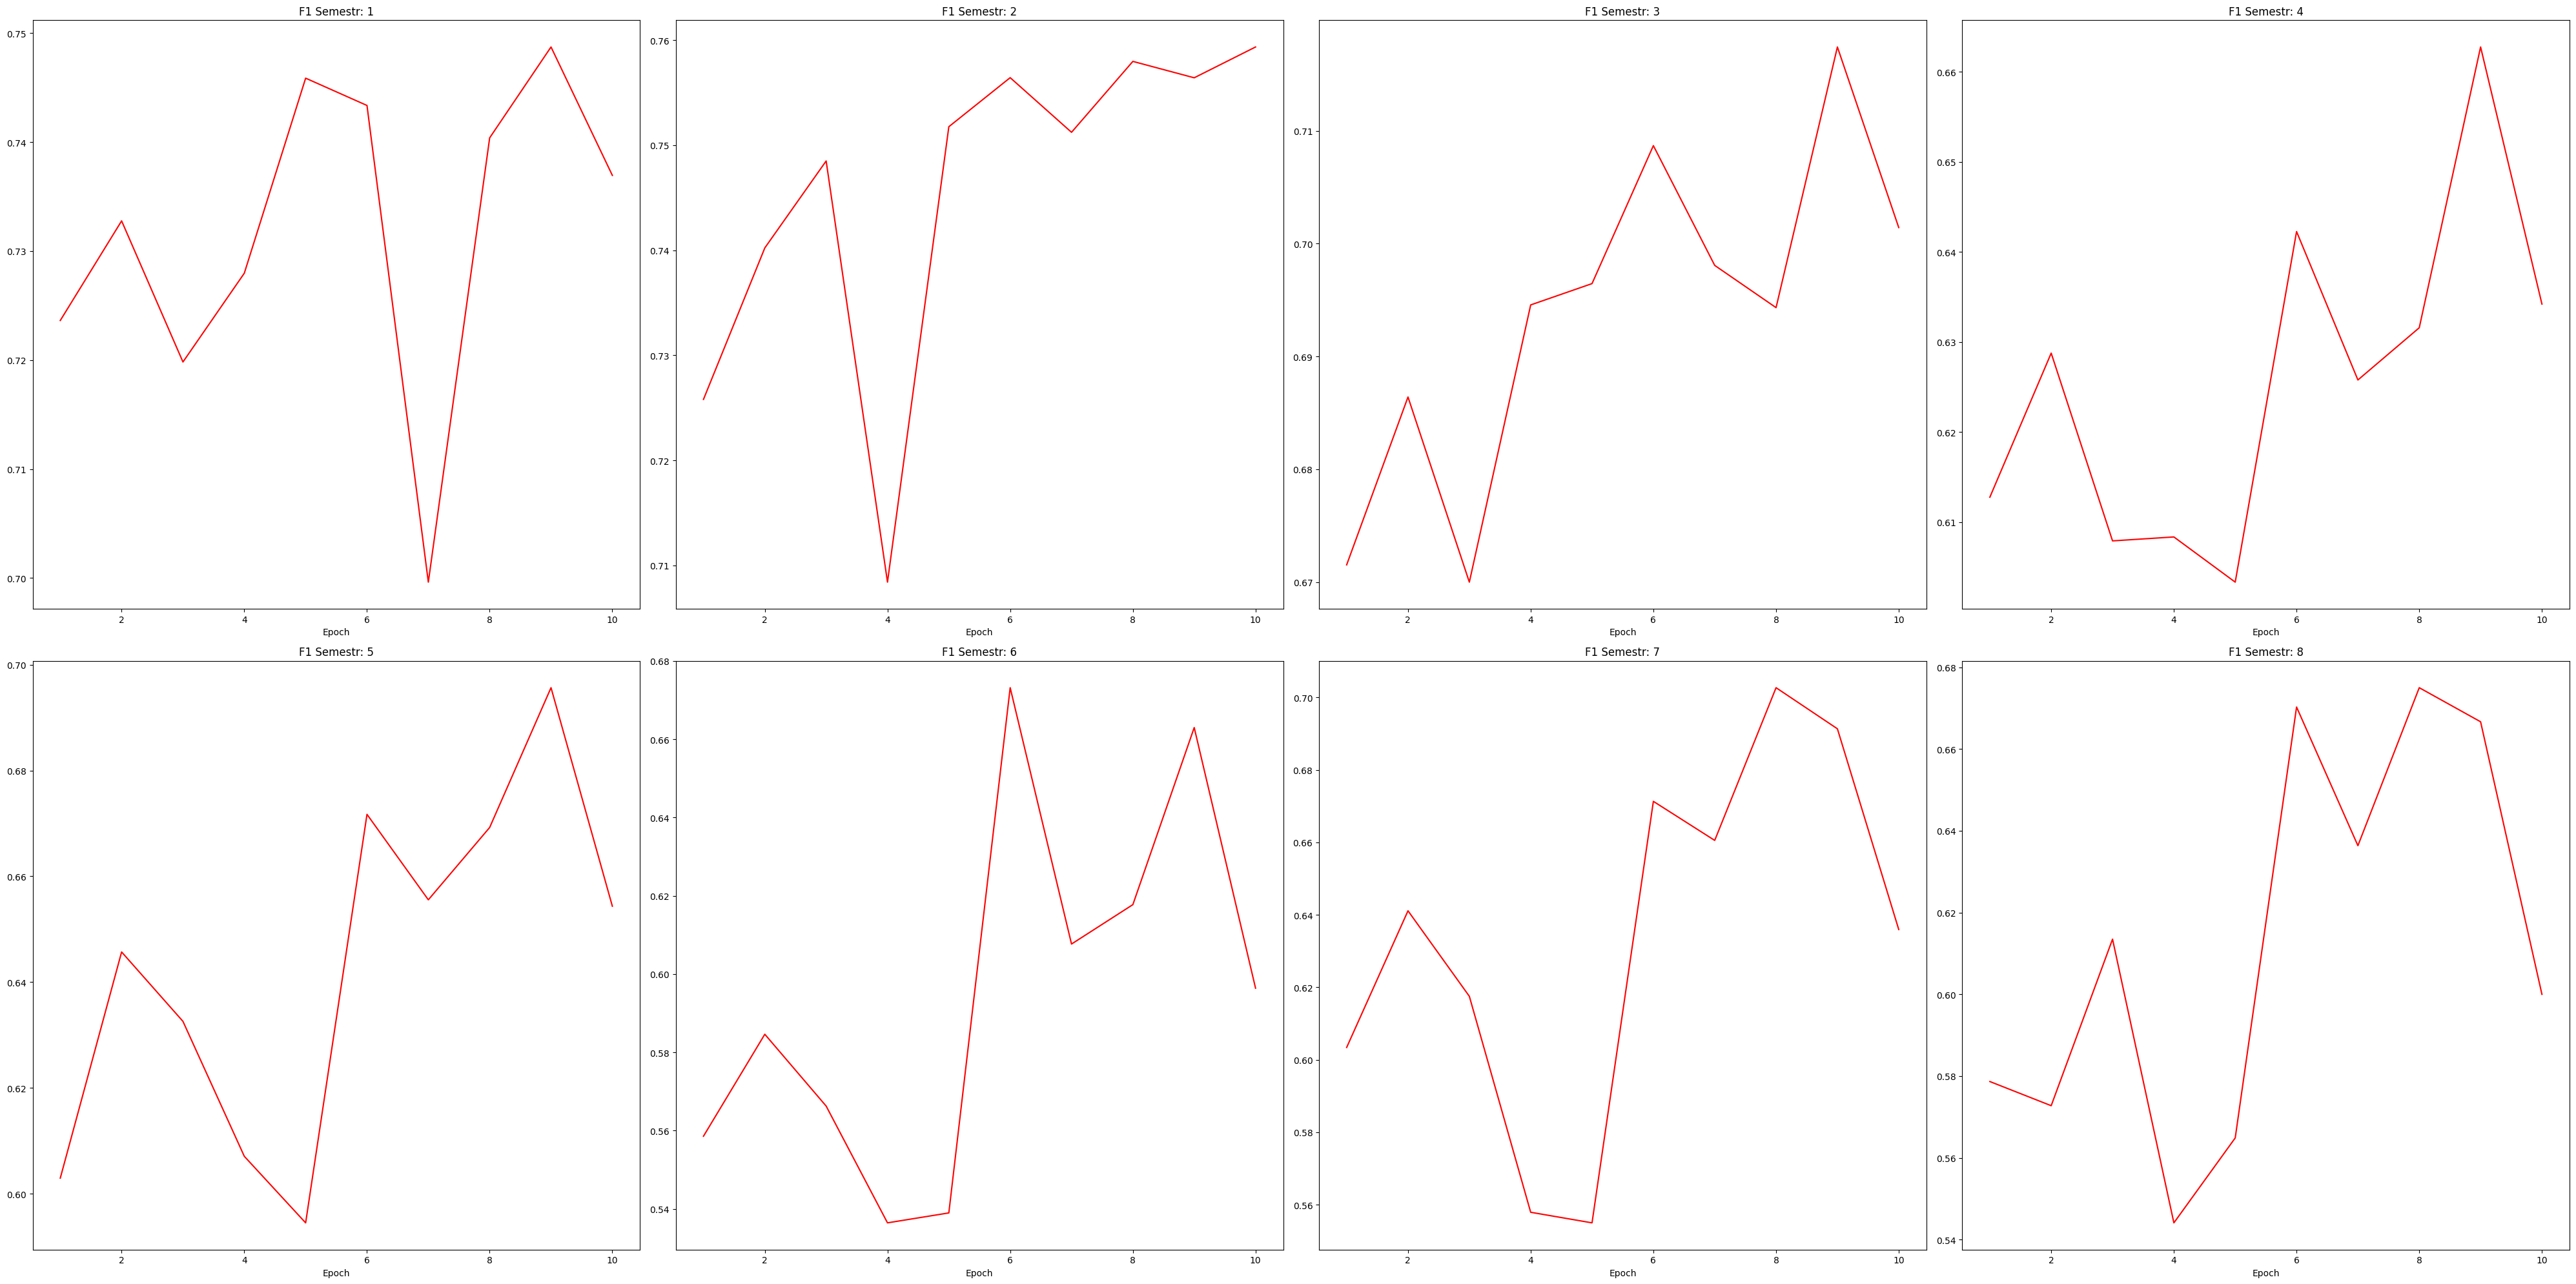

In [25]:
model_rnn = OtchislenieModel(hidden_dim=256, input_size=max_len_data, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_rnn.parameters())

model_rnn = train_model(model_rnn, optimizer, criterion, num_epoch=10)

Min Loss = 0.4238370466649021
Curr F1 = [0.75677711 0.7605774  0.72928177 0.68627451 0.68928571 0.69491525
 0.66666667 0.675     ]
Max F1 = [0.7592206  0.78014842 0.73613193 0.69942857 0.70113086 0.71270718
 0.71489362 0.70658683]
Curr AUC_ROC = [0.77365275 0.8015233  0.80042158 0.7823455  0.78925519 0.79258901
 0.79408325 0.81026828]
Max AUC_ROC = [0.77365275 0.81617742 0.80968441 0.80042531 0.81584484 0.806637
 0.83361227 0.84406597]
Семестр 1
              precision    recall  f1-score   support

         0.0       0.84      0.69      0.76      1555
         1.0       0.69      0.84      0.76      1299

    accuracy                           0.76      2854
   macro avg       0.77      0.76      0.76      2854
weighted avg       0.77      0.76      0.76      2854

Семестр 2
              precision    recall  f1-score   support

         0.0       0.87      0.82      0.84      1555
         1.0       0.75      0.81      0.78      1036

    accuracy                           0.82      

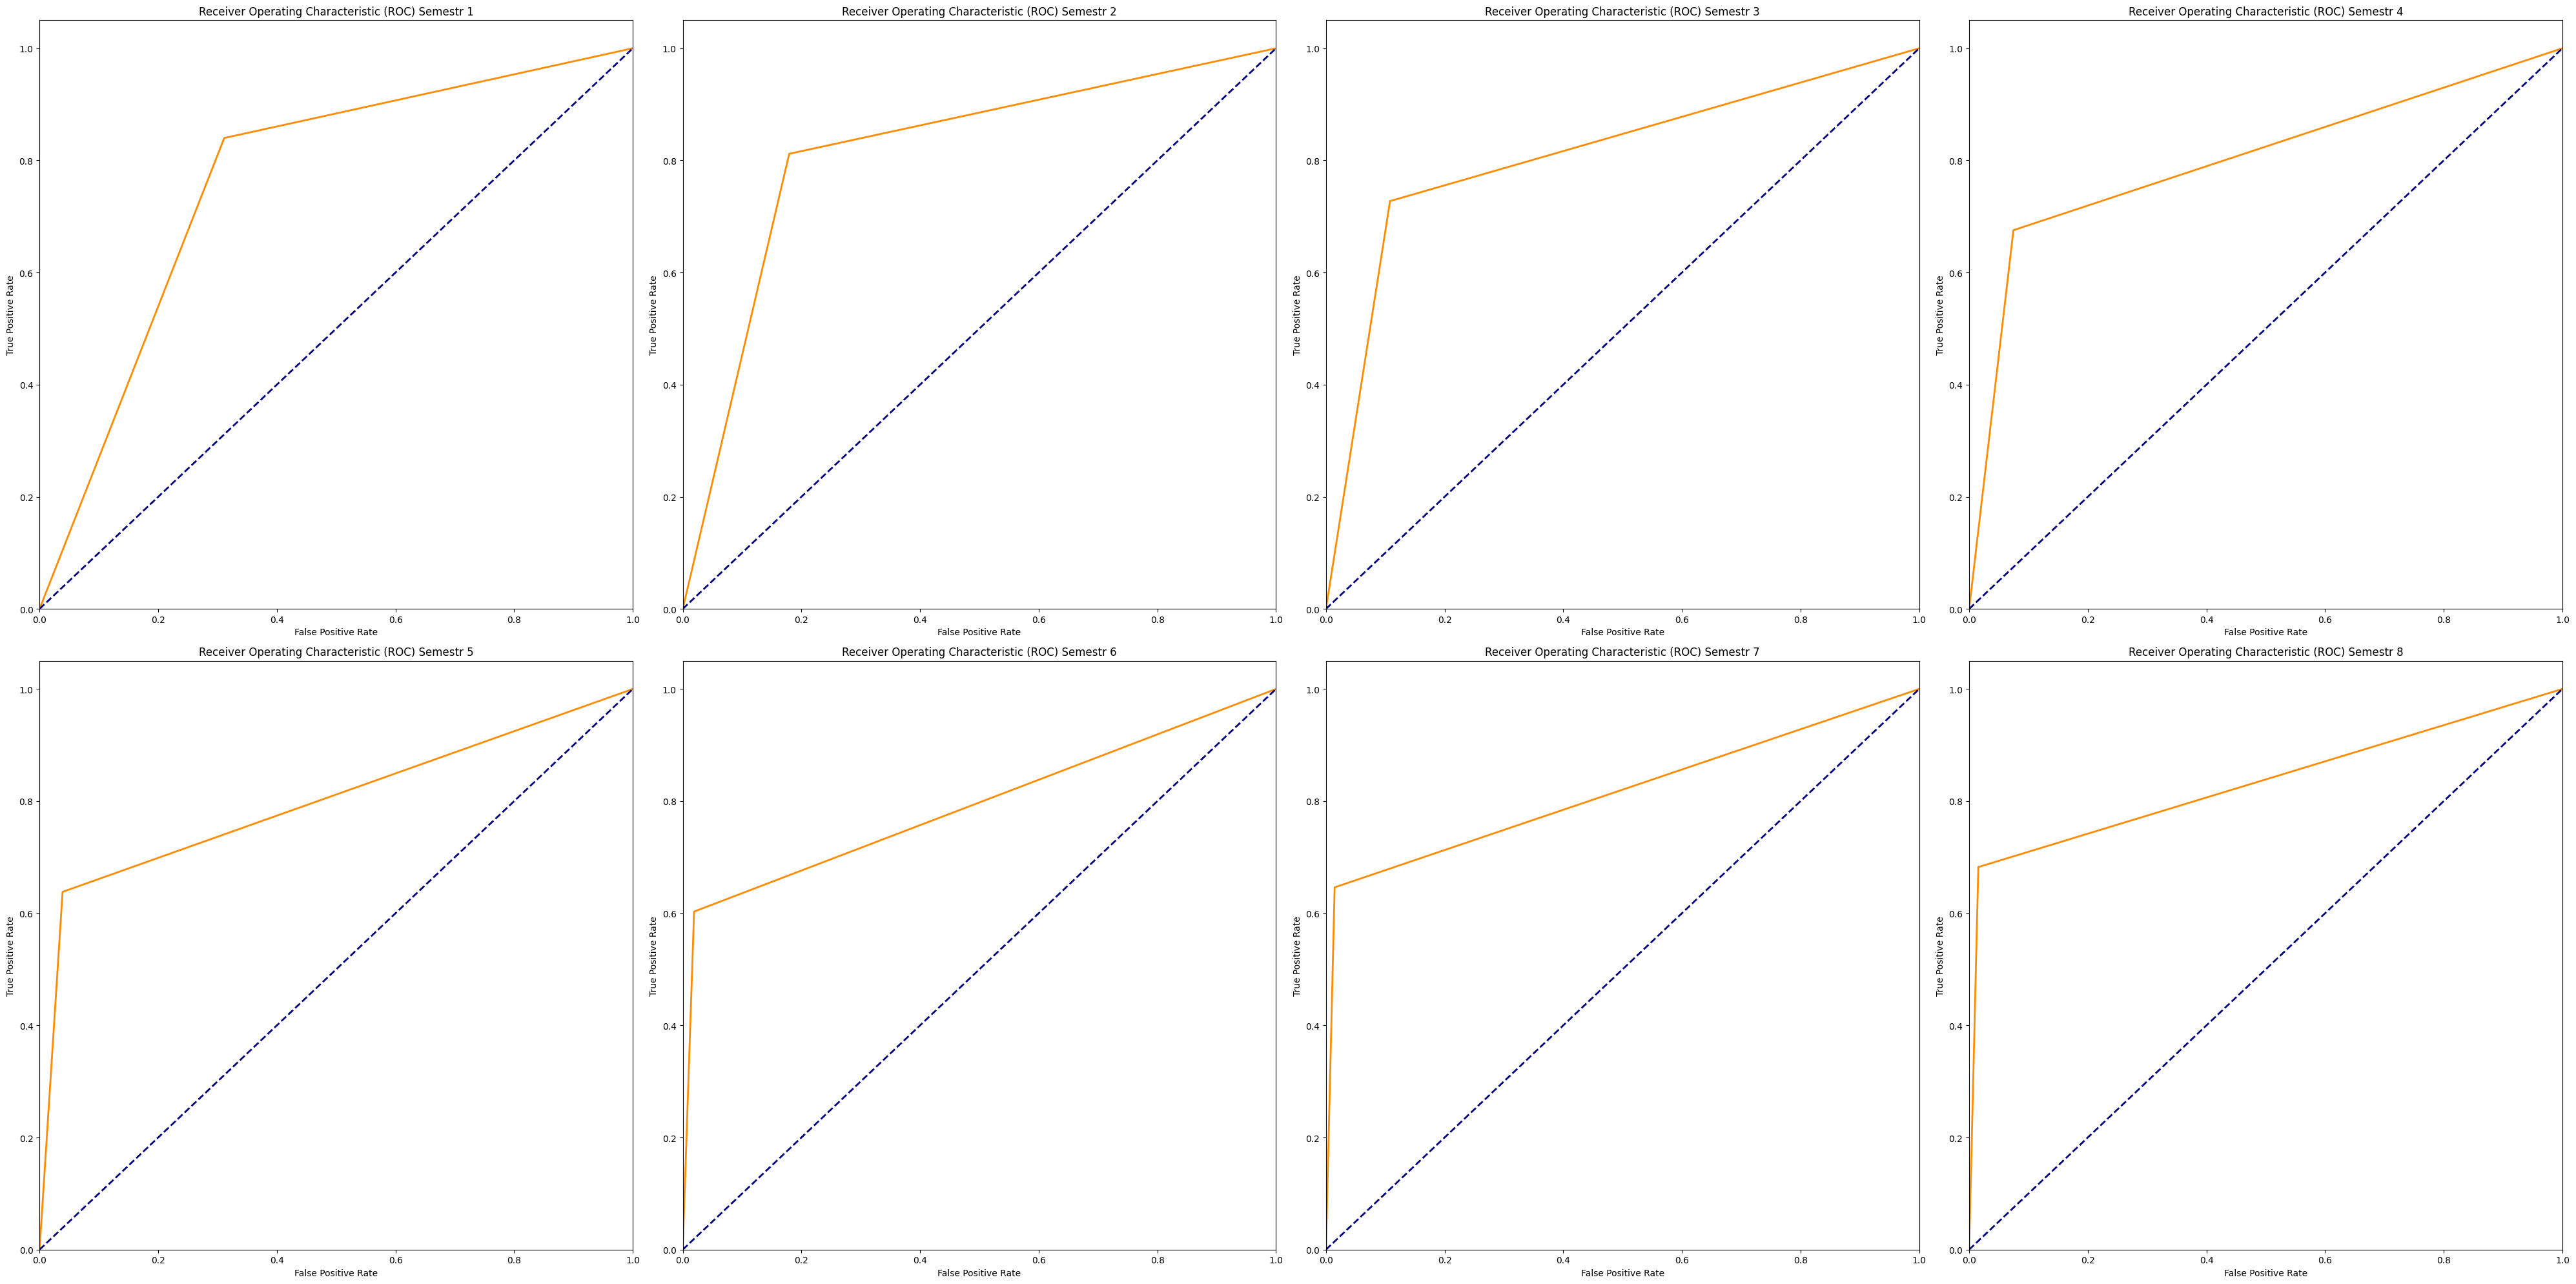

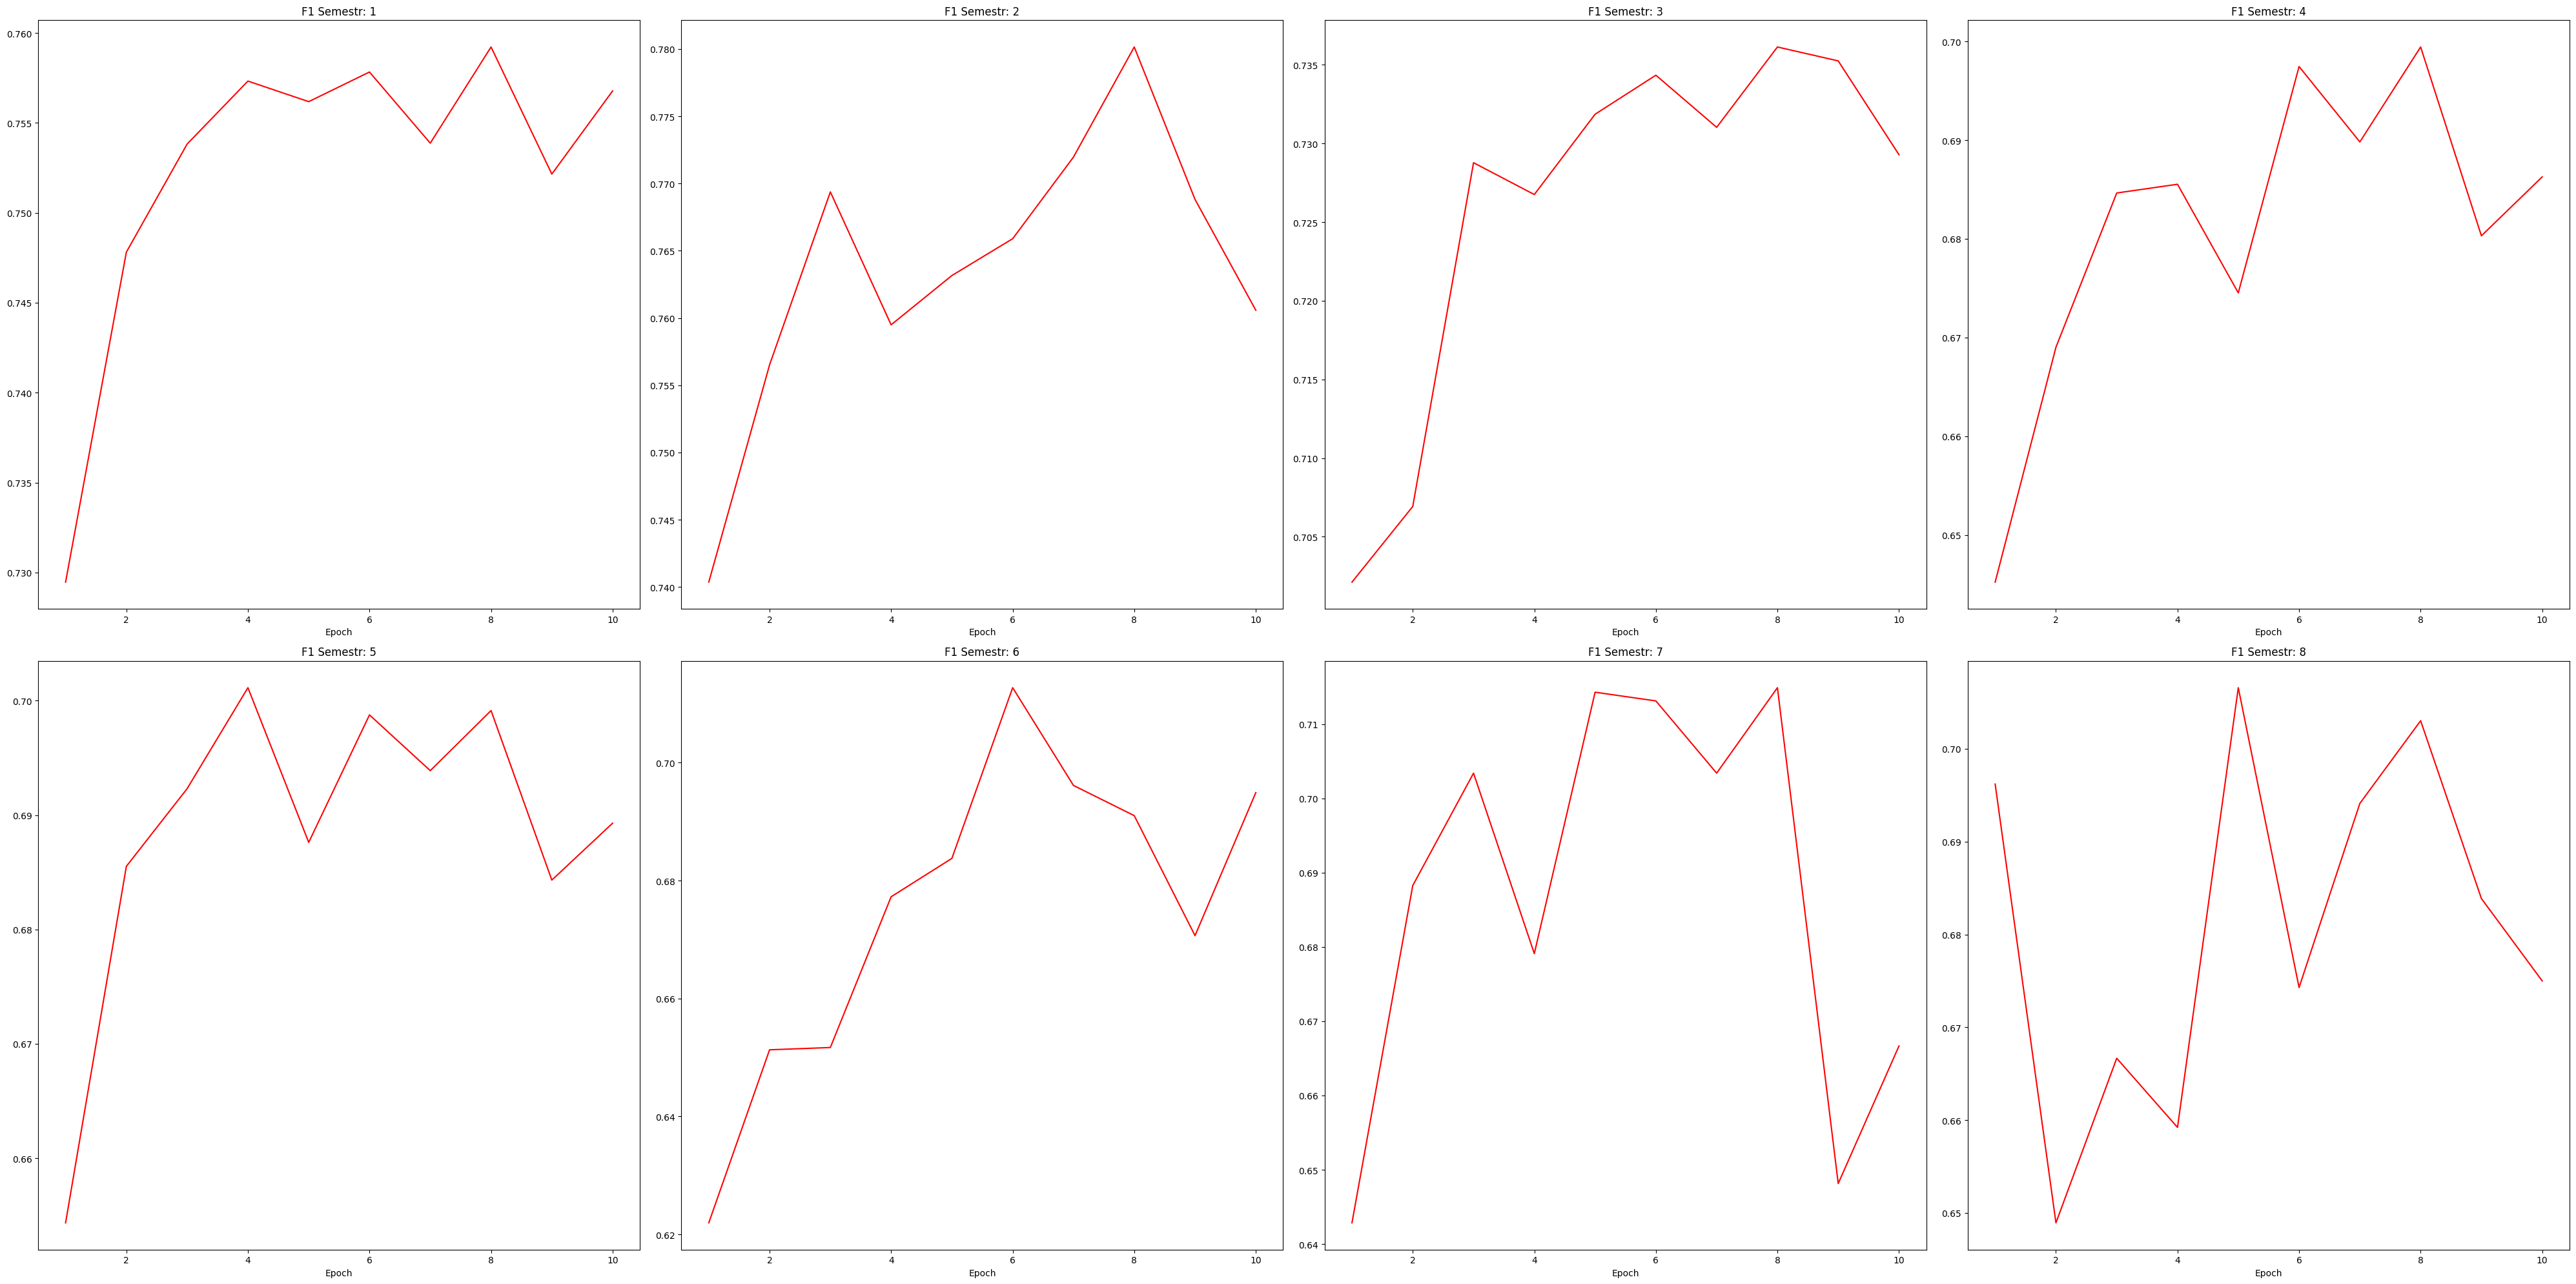

In [26]:
model_rnn = OtchislenieModel(hidden_dim=128, input_size=max_len_data, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_rnn.parameters())

model_rnn = train_model(model_rnn, optimizer, criterion, num_epoch=10)

Min Loss = 0.4501543834385112
Curr F1 = [0.74336283 0.7357775  0.7040887  0.64968153 0.68292683 0.67024129
 0.68571429 0.66666667]
Max F1 = [0.74817137 0.75626204 0.71630678 0.65771812 0.68292683 0.67024129
 0.71111111 0.67924528]
Curr AUC_ROC = [0.73777578 0.7721359  0.79269501 0.77886804 0.80374753 0.79189886
 0.812268   0.81474515]
Max AUC_ROC = [0.75662753 0.79686743 0.79616768 0.77886804 0.80490279 0.81187436
 0.85157708 0.85099004]
Семестр 1
              precision    recall  f1-score   support

         0.0       0.82      0.67      0.74      1555
         1.0       0.68      0.82      0.74      1299

    accuracy                           0.74      2854
   macro avg       0.75      0.75      0.74      2854
weighted avg       0.75      0.74      0.74      2854

Семестр 2
              precision    recall  f1-score   support

         0.0       0.85      0.79      0.82      1555
         1.0       0.72      0.79      0.75      1036

    accuracy                           0.79    

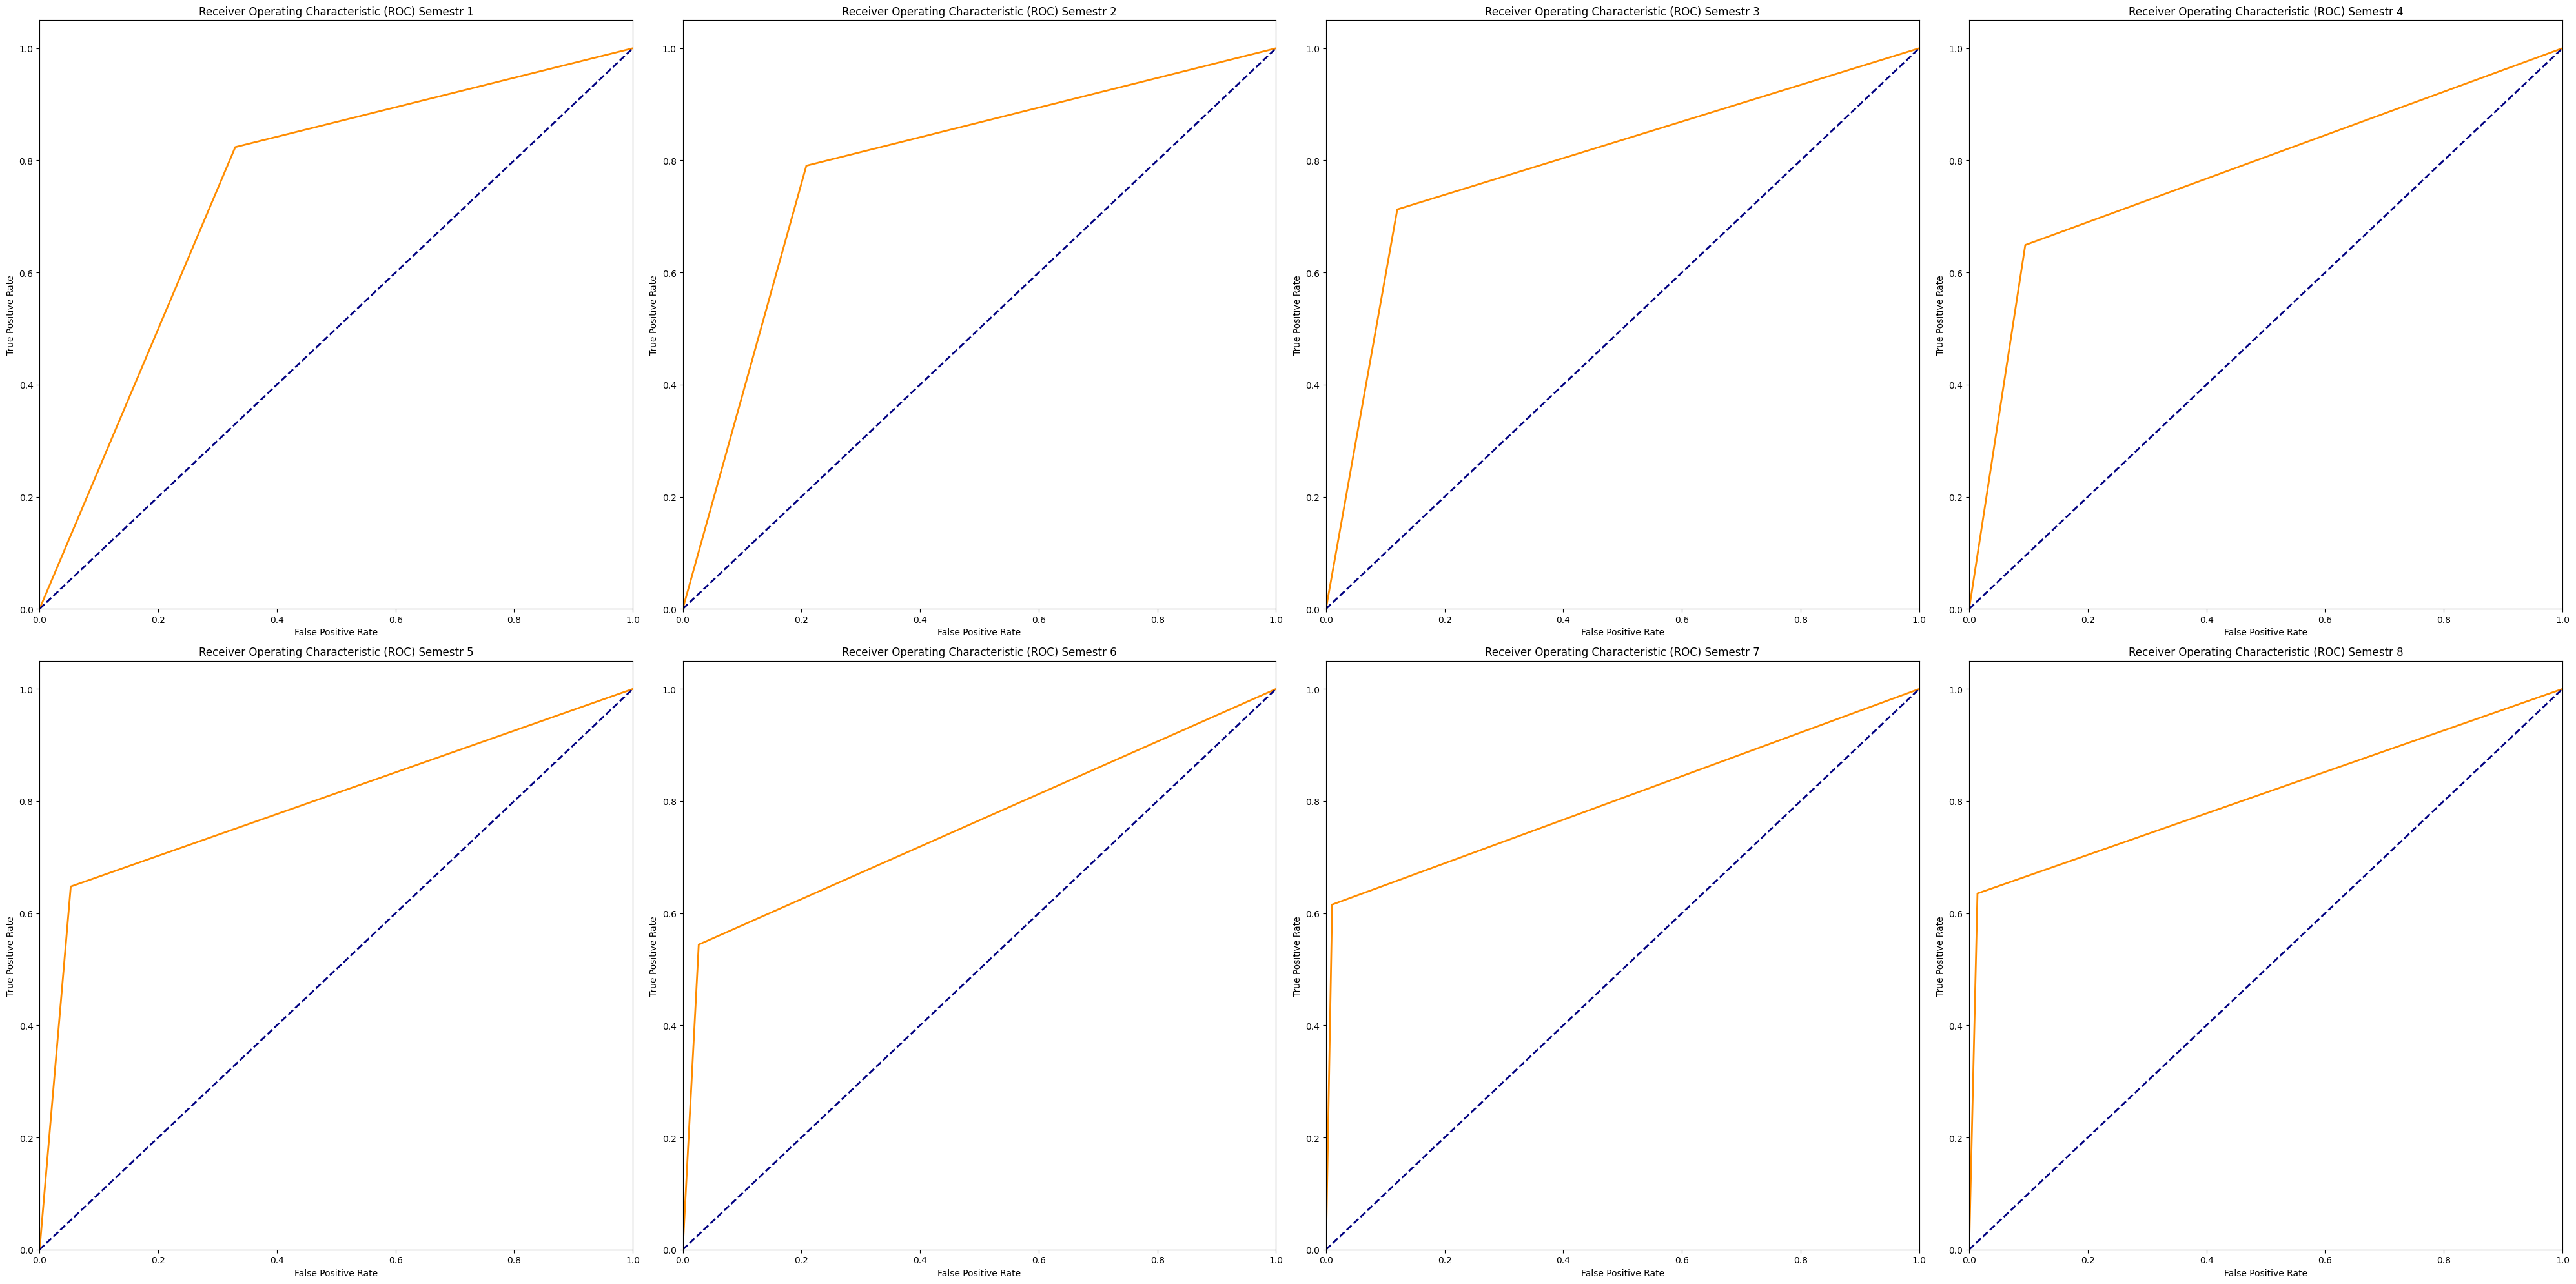

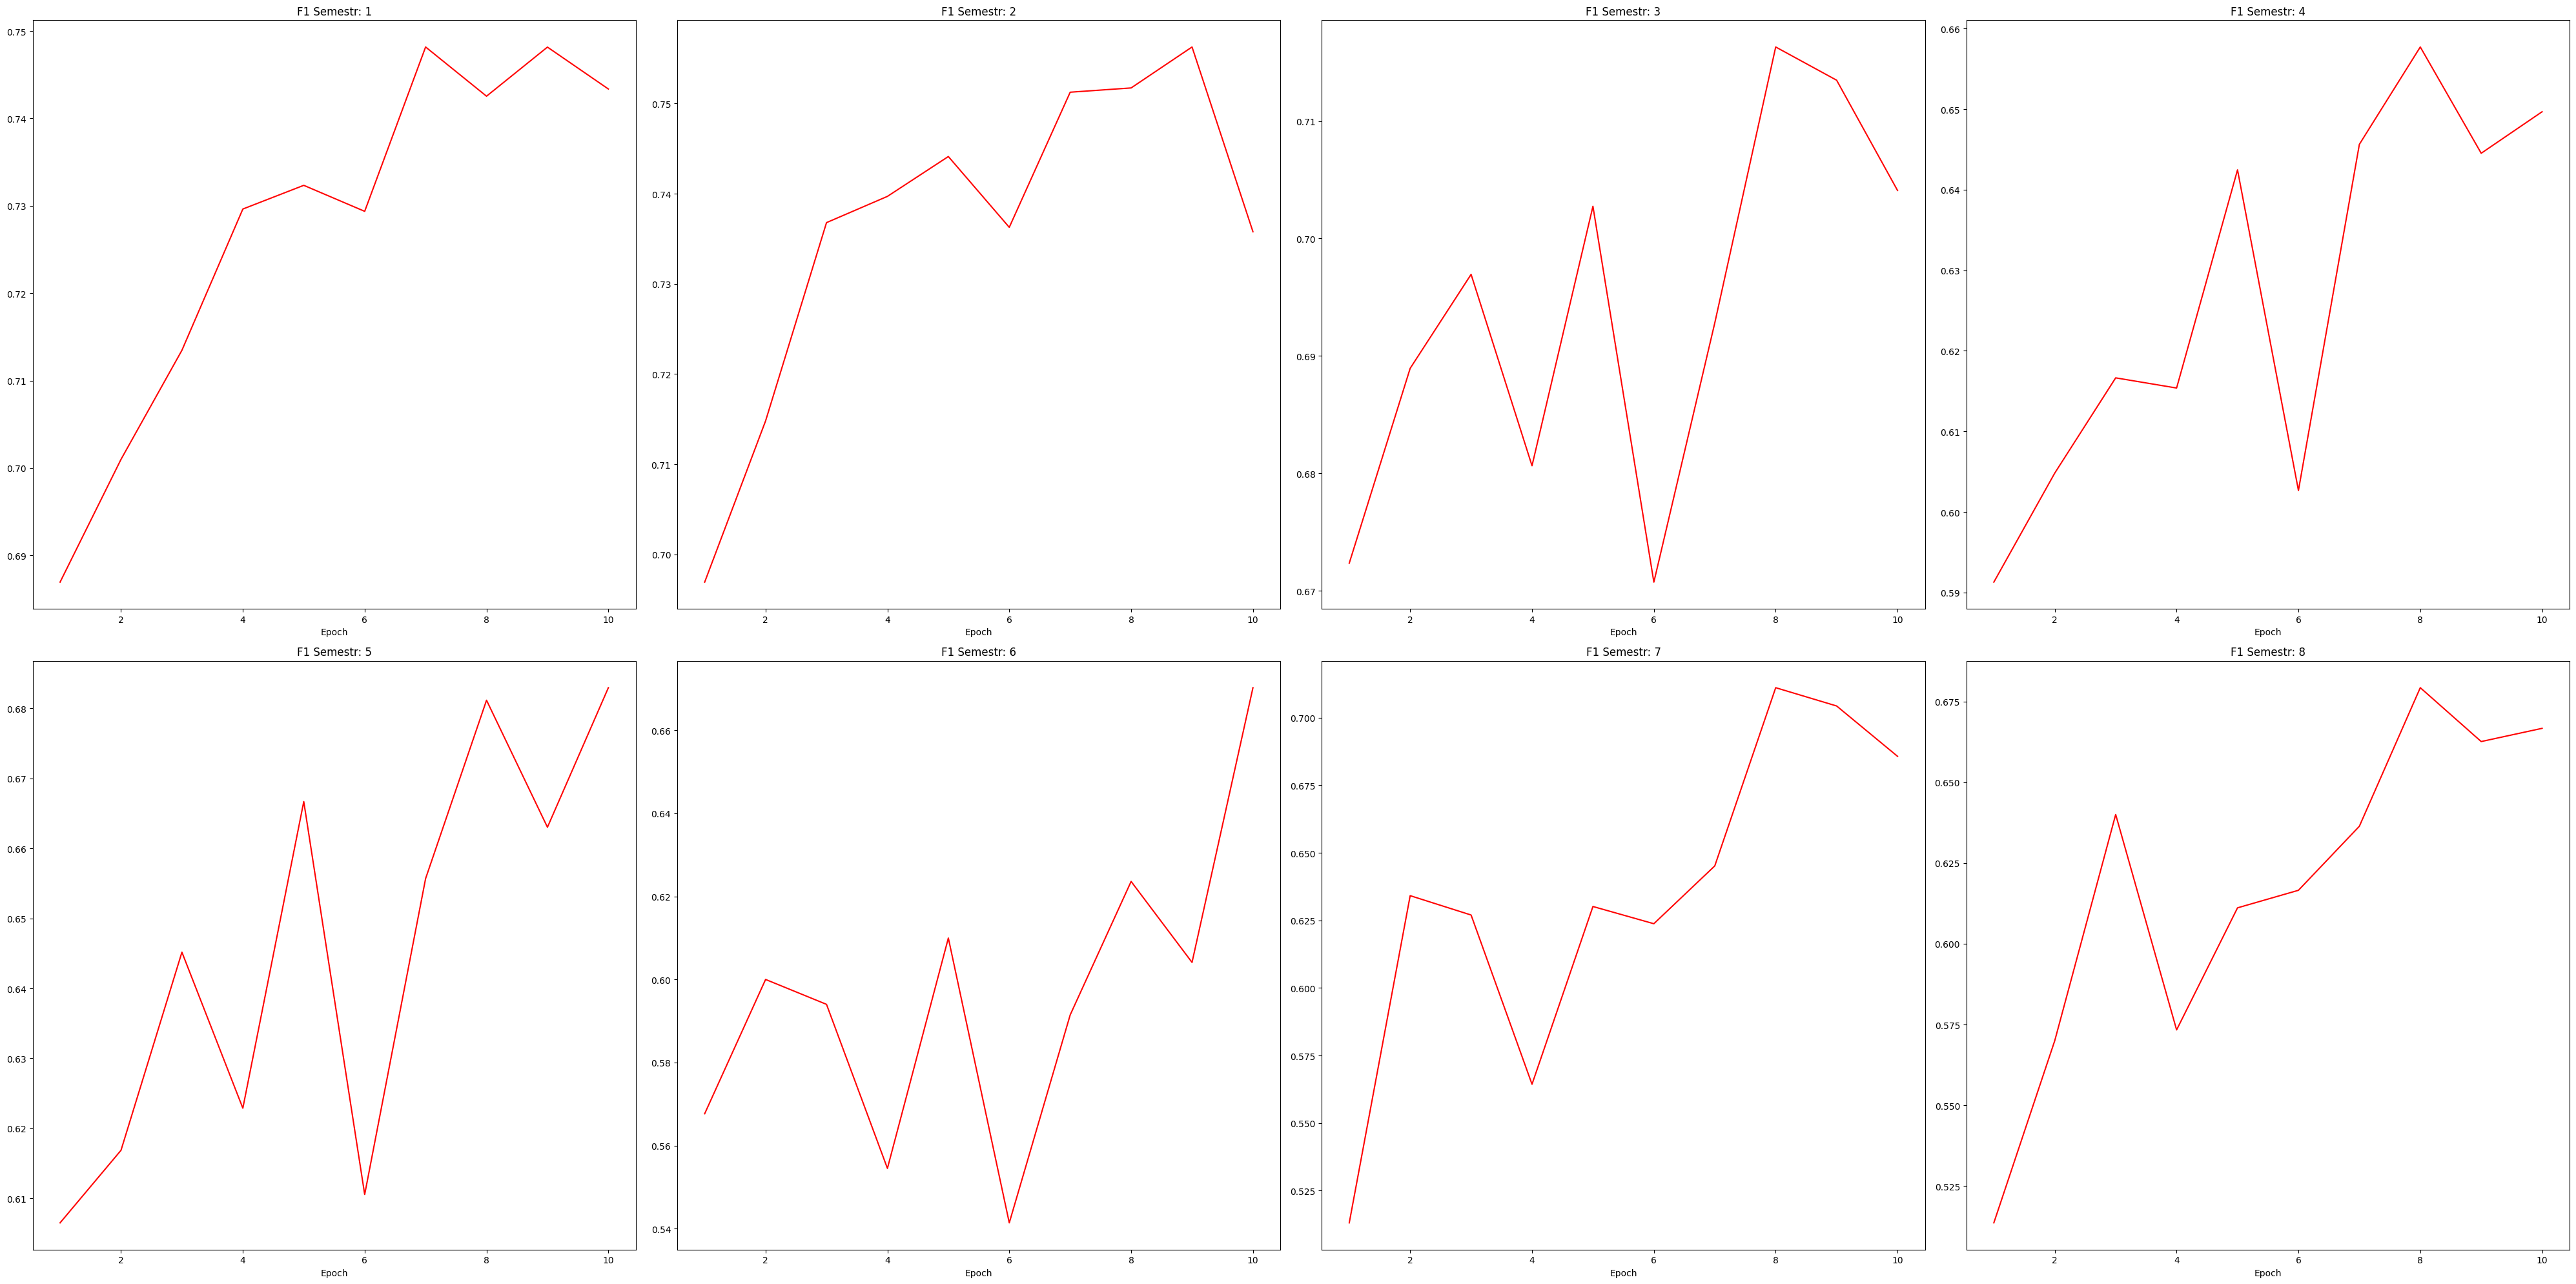

In [27]:
model_rnn = OtchislenieModel(hidden_dim=512, input_size=max_len_data, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_rnn.parameters())

model_rnn = train_model(model_rnn, optimizer, criterion, num_epoch=10)

GRU Base Structure

Min Loss = 0.45711918099761656
Curr F1 = [0.74532796 0.73976915 0.70216306 0.63990268 0.66324786 0.64082687
 0.66409266 0.65934066]
Max F1 = [0.74532796 0.74641148 0.7057903  0.65747126 0.66445183 0.66666667
 0.68164794 0.67857143]
Curr AUC_ROC = [0.75865754 0.7871963  0.77883053 0.75618144 0.78295294 0.78451367
 0.8157762  0.83994047]
Max AUC_ROC = [0.75865754 0.78834498 0.785602   0.773524   0.78886071 0.79662023
 0.83396095 0.83994047]
Семестр 1
              precision    recall  f1-score   support

         0.0       0.84      0.62      0.71      1555
         1.0       0.65      0.86      0.74      1299

    accuracy                           0.73      2854
   macro avg       0.75      0.74      0.73      2854
weighted avg       0.75      0.73      0.73      2854

Семестр 2
              precision    recall  f1-score   support

         0.0       0.84      0.76      0.80      1555
         1.0       0.69      0.78      0.73      1036

    accuracy                           0.77   

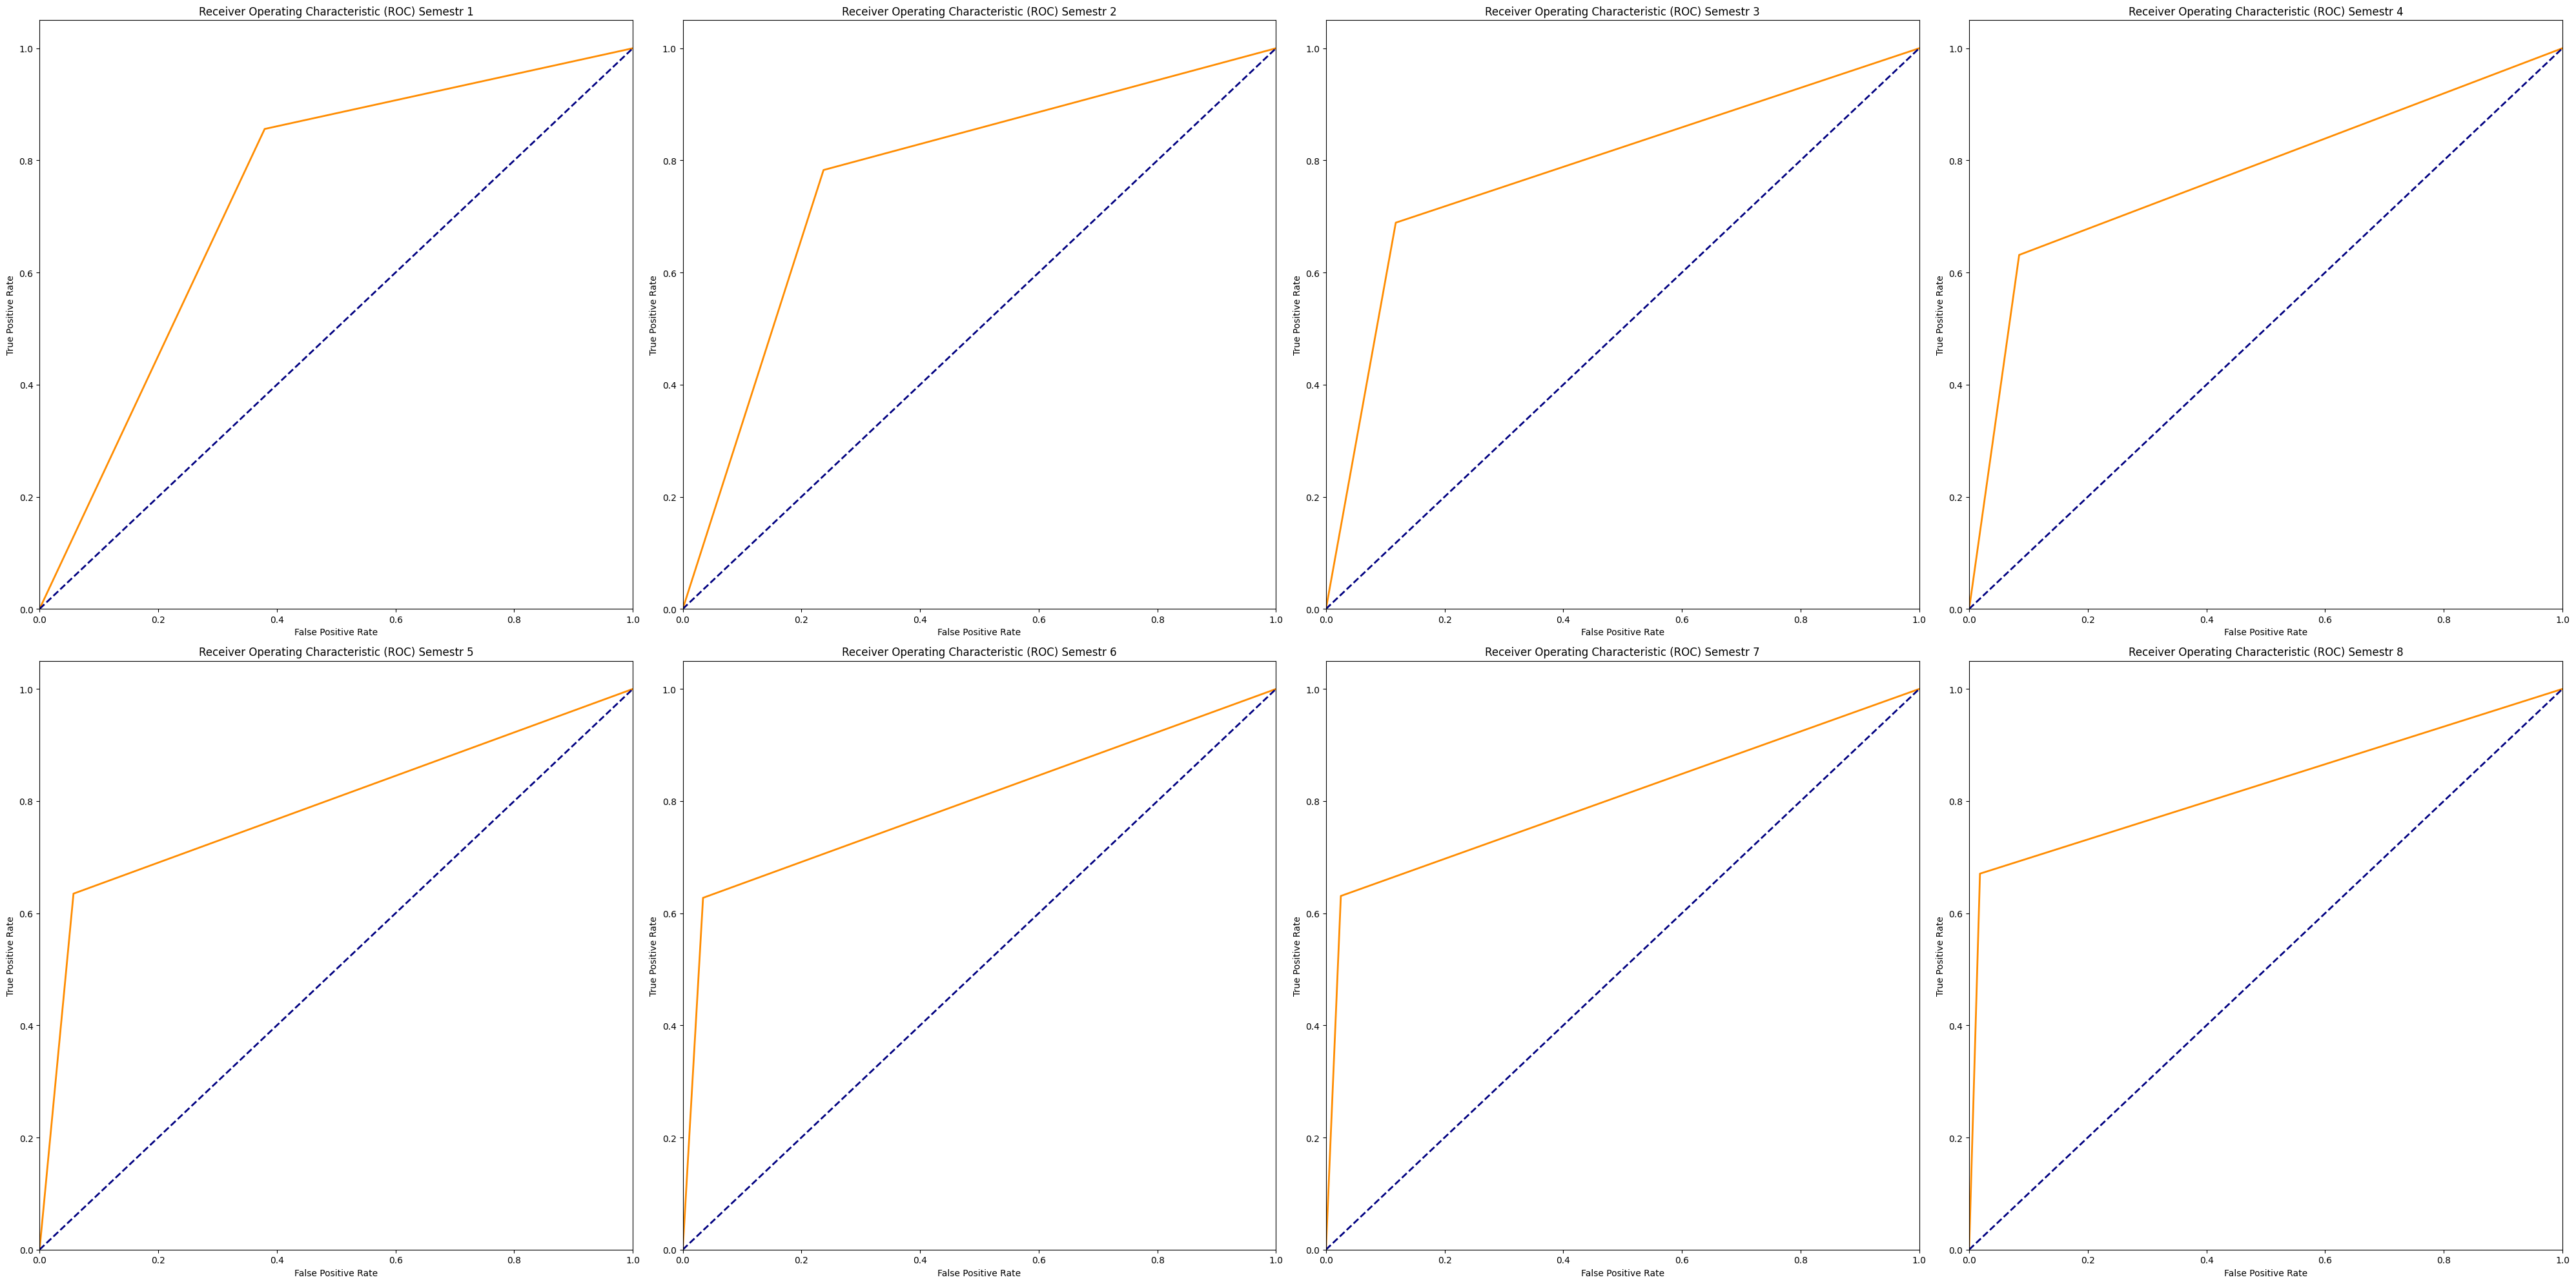

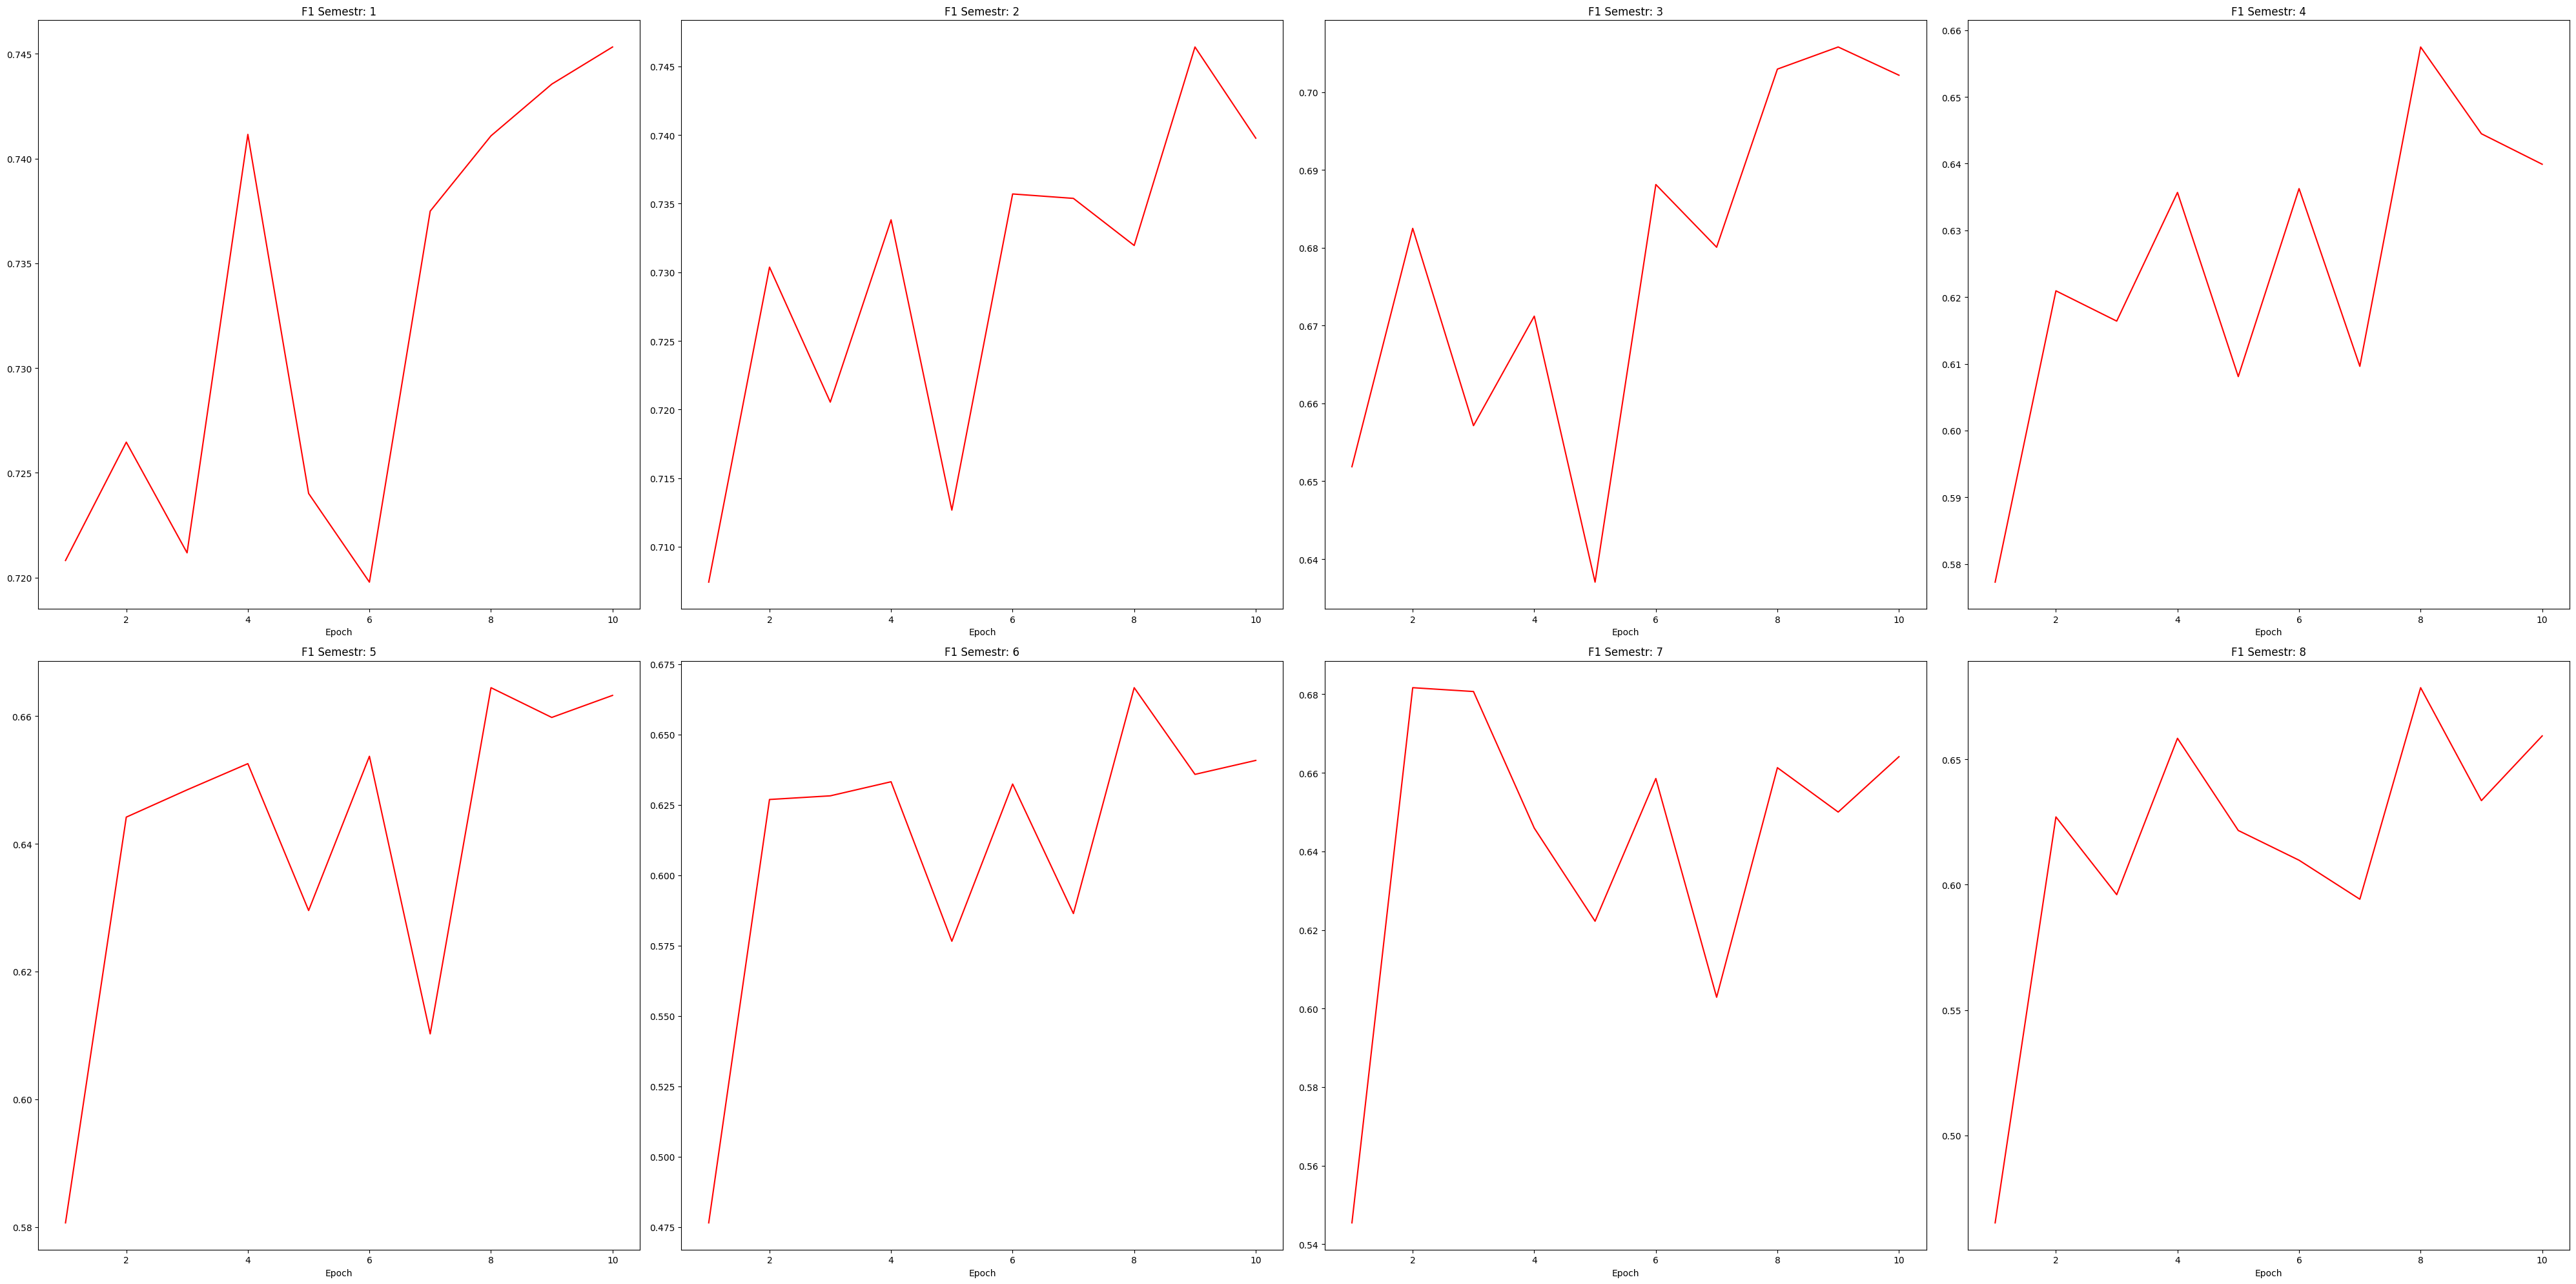

In [28]:
model_gru = OtchislenieModel_GRU(hidden_dim=256, input_size=max_len_data, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_gru.parameters())

model_gru = train_model(model_gru, optimizer, criterion, num_epoch=10)

Min Loss = 0.4134927828674958
Curr F1 = [0.75929142 0.77490421 0.73256705 0.6835443  0.7345576  0.72043011
 0.71311475 0.67857143]
Max F1 = [0.76585193 0.78265107 0.74736842 0.70071259 0.73773266 0.72043011
 0.71311475 0.74683544]
Curr AUC_ROC = [0.7641166  0.81230897 0.80519948 0.78952628 0.82816756 0.81724716
 0.82520116 0.82615849]
Max AUC_ROC = [0.7767766  0.81905952 0.81734429 0.79536253 0.82816756 0.81724716
 0.82520116 0.85486751]
Семестр 1
              precision    recall  f1-score   support

         0.0       0.84      0.70      0.76      1555
         1.0       0.70      0.84      0.77      1299

    accuracy                           0.76      2854
   macro avg       0.77      0.77      0.76      2854
weighted avg       0.78      0.76      0.76      2854

Семестр 2
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85      1555
         1.0       0.78      0.77      0.77      1036

    accuracy                           0.82    

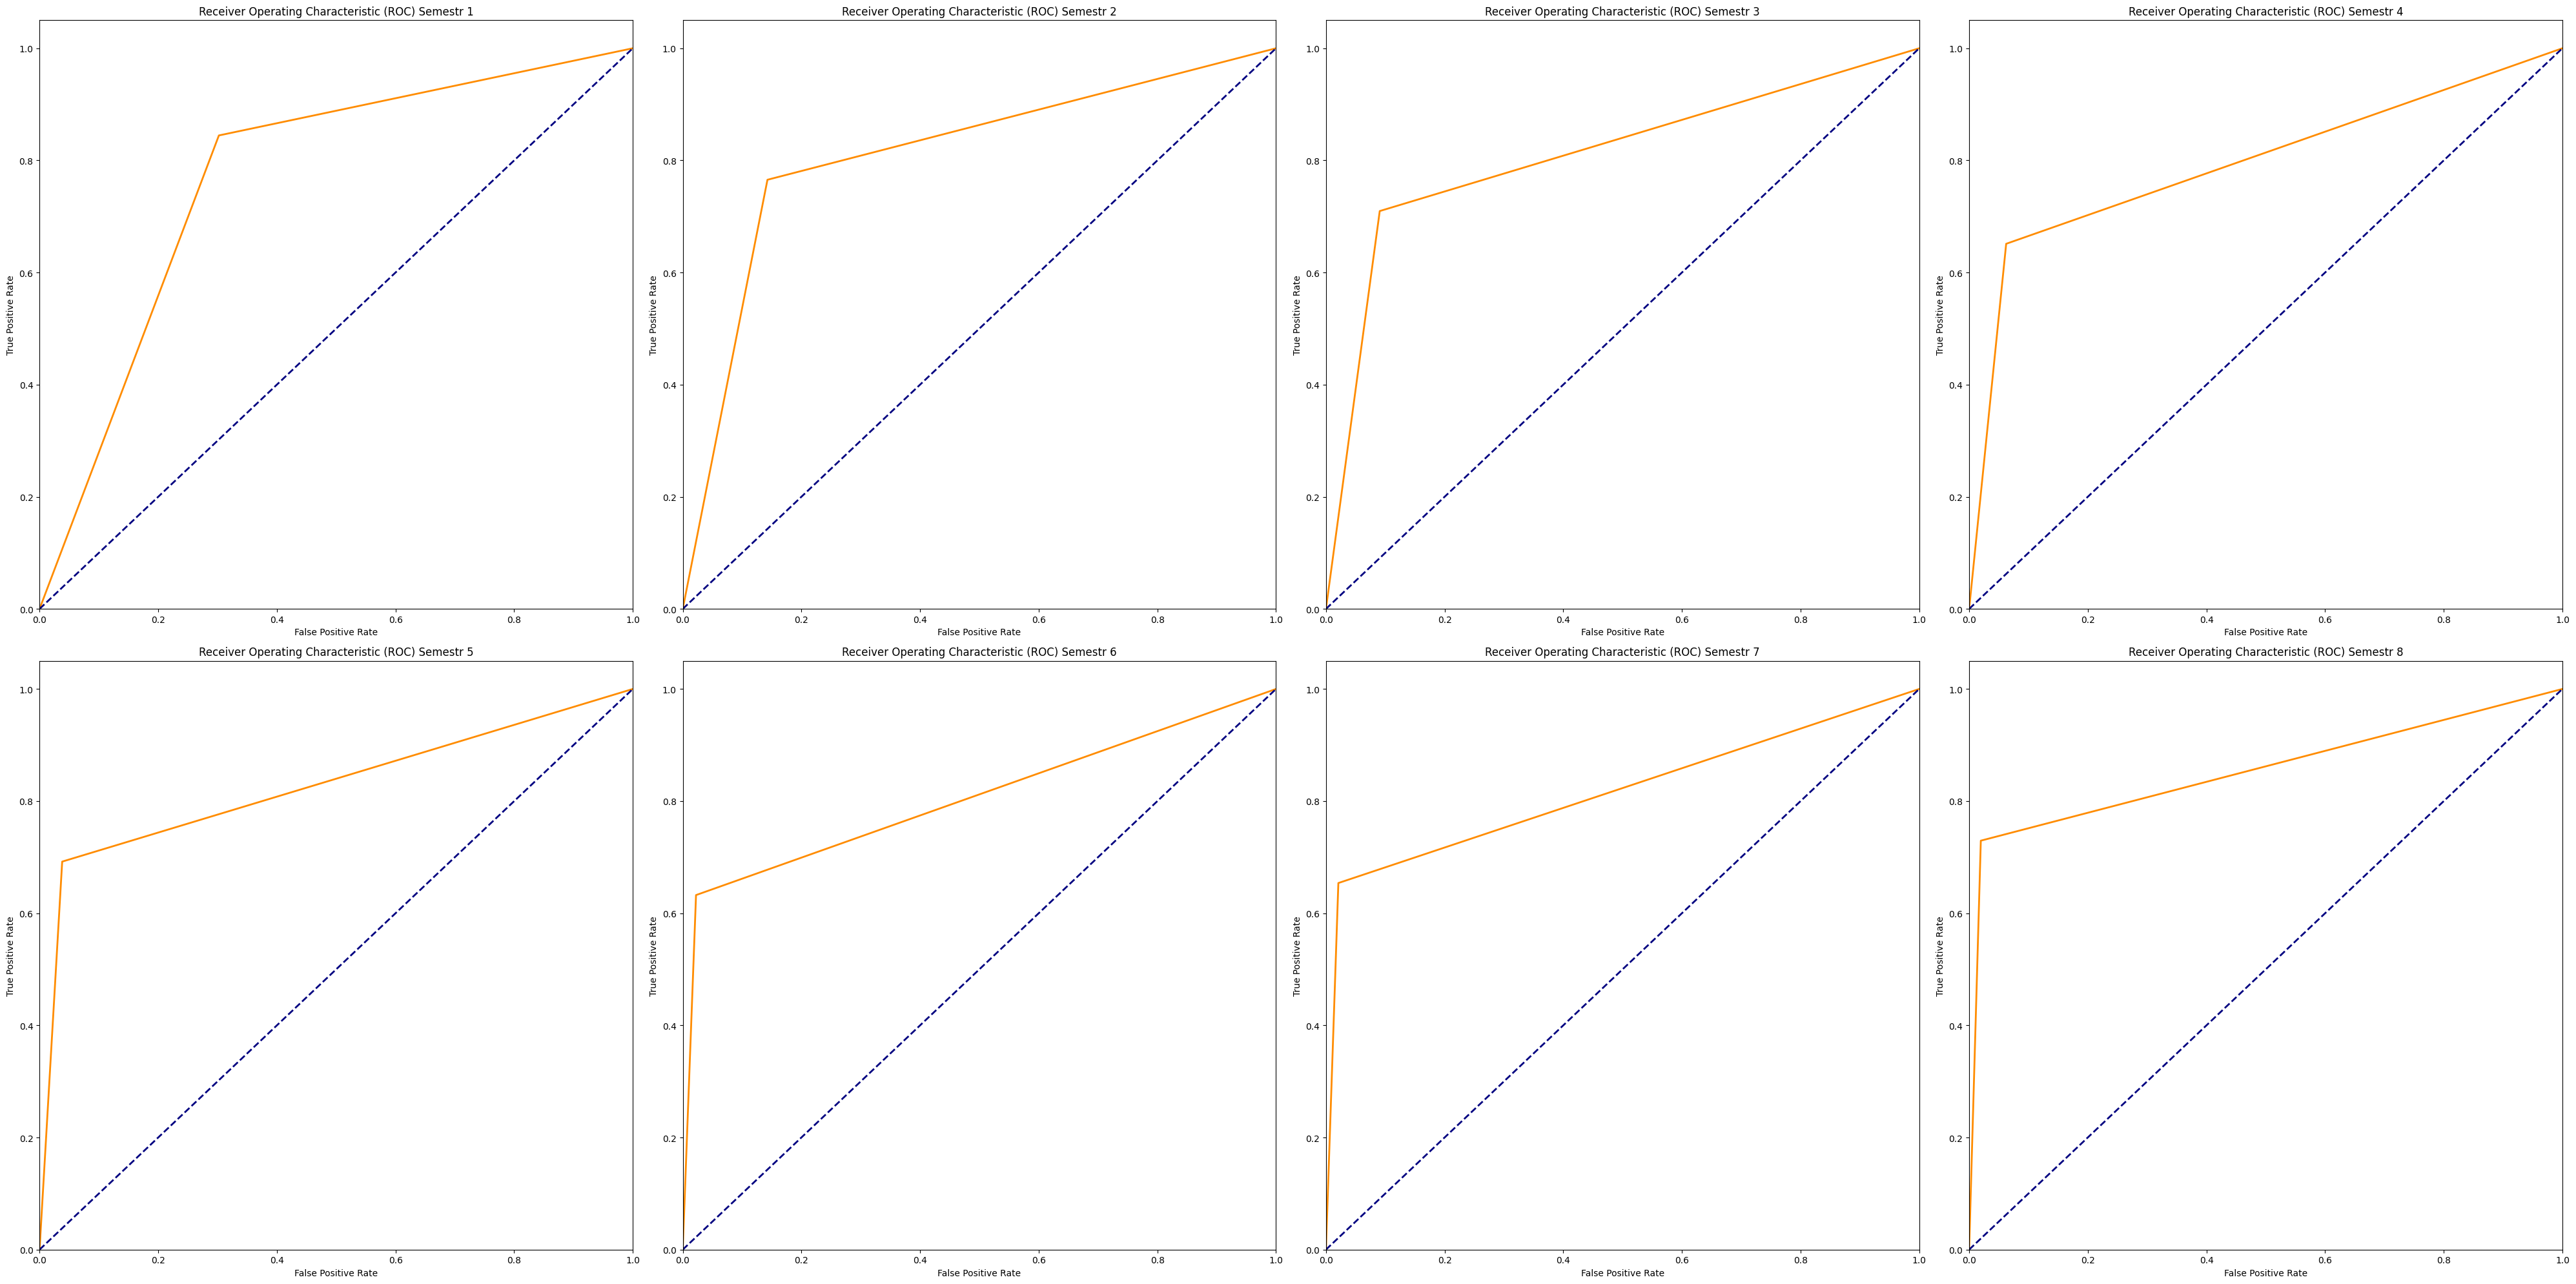

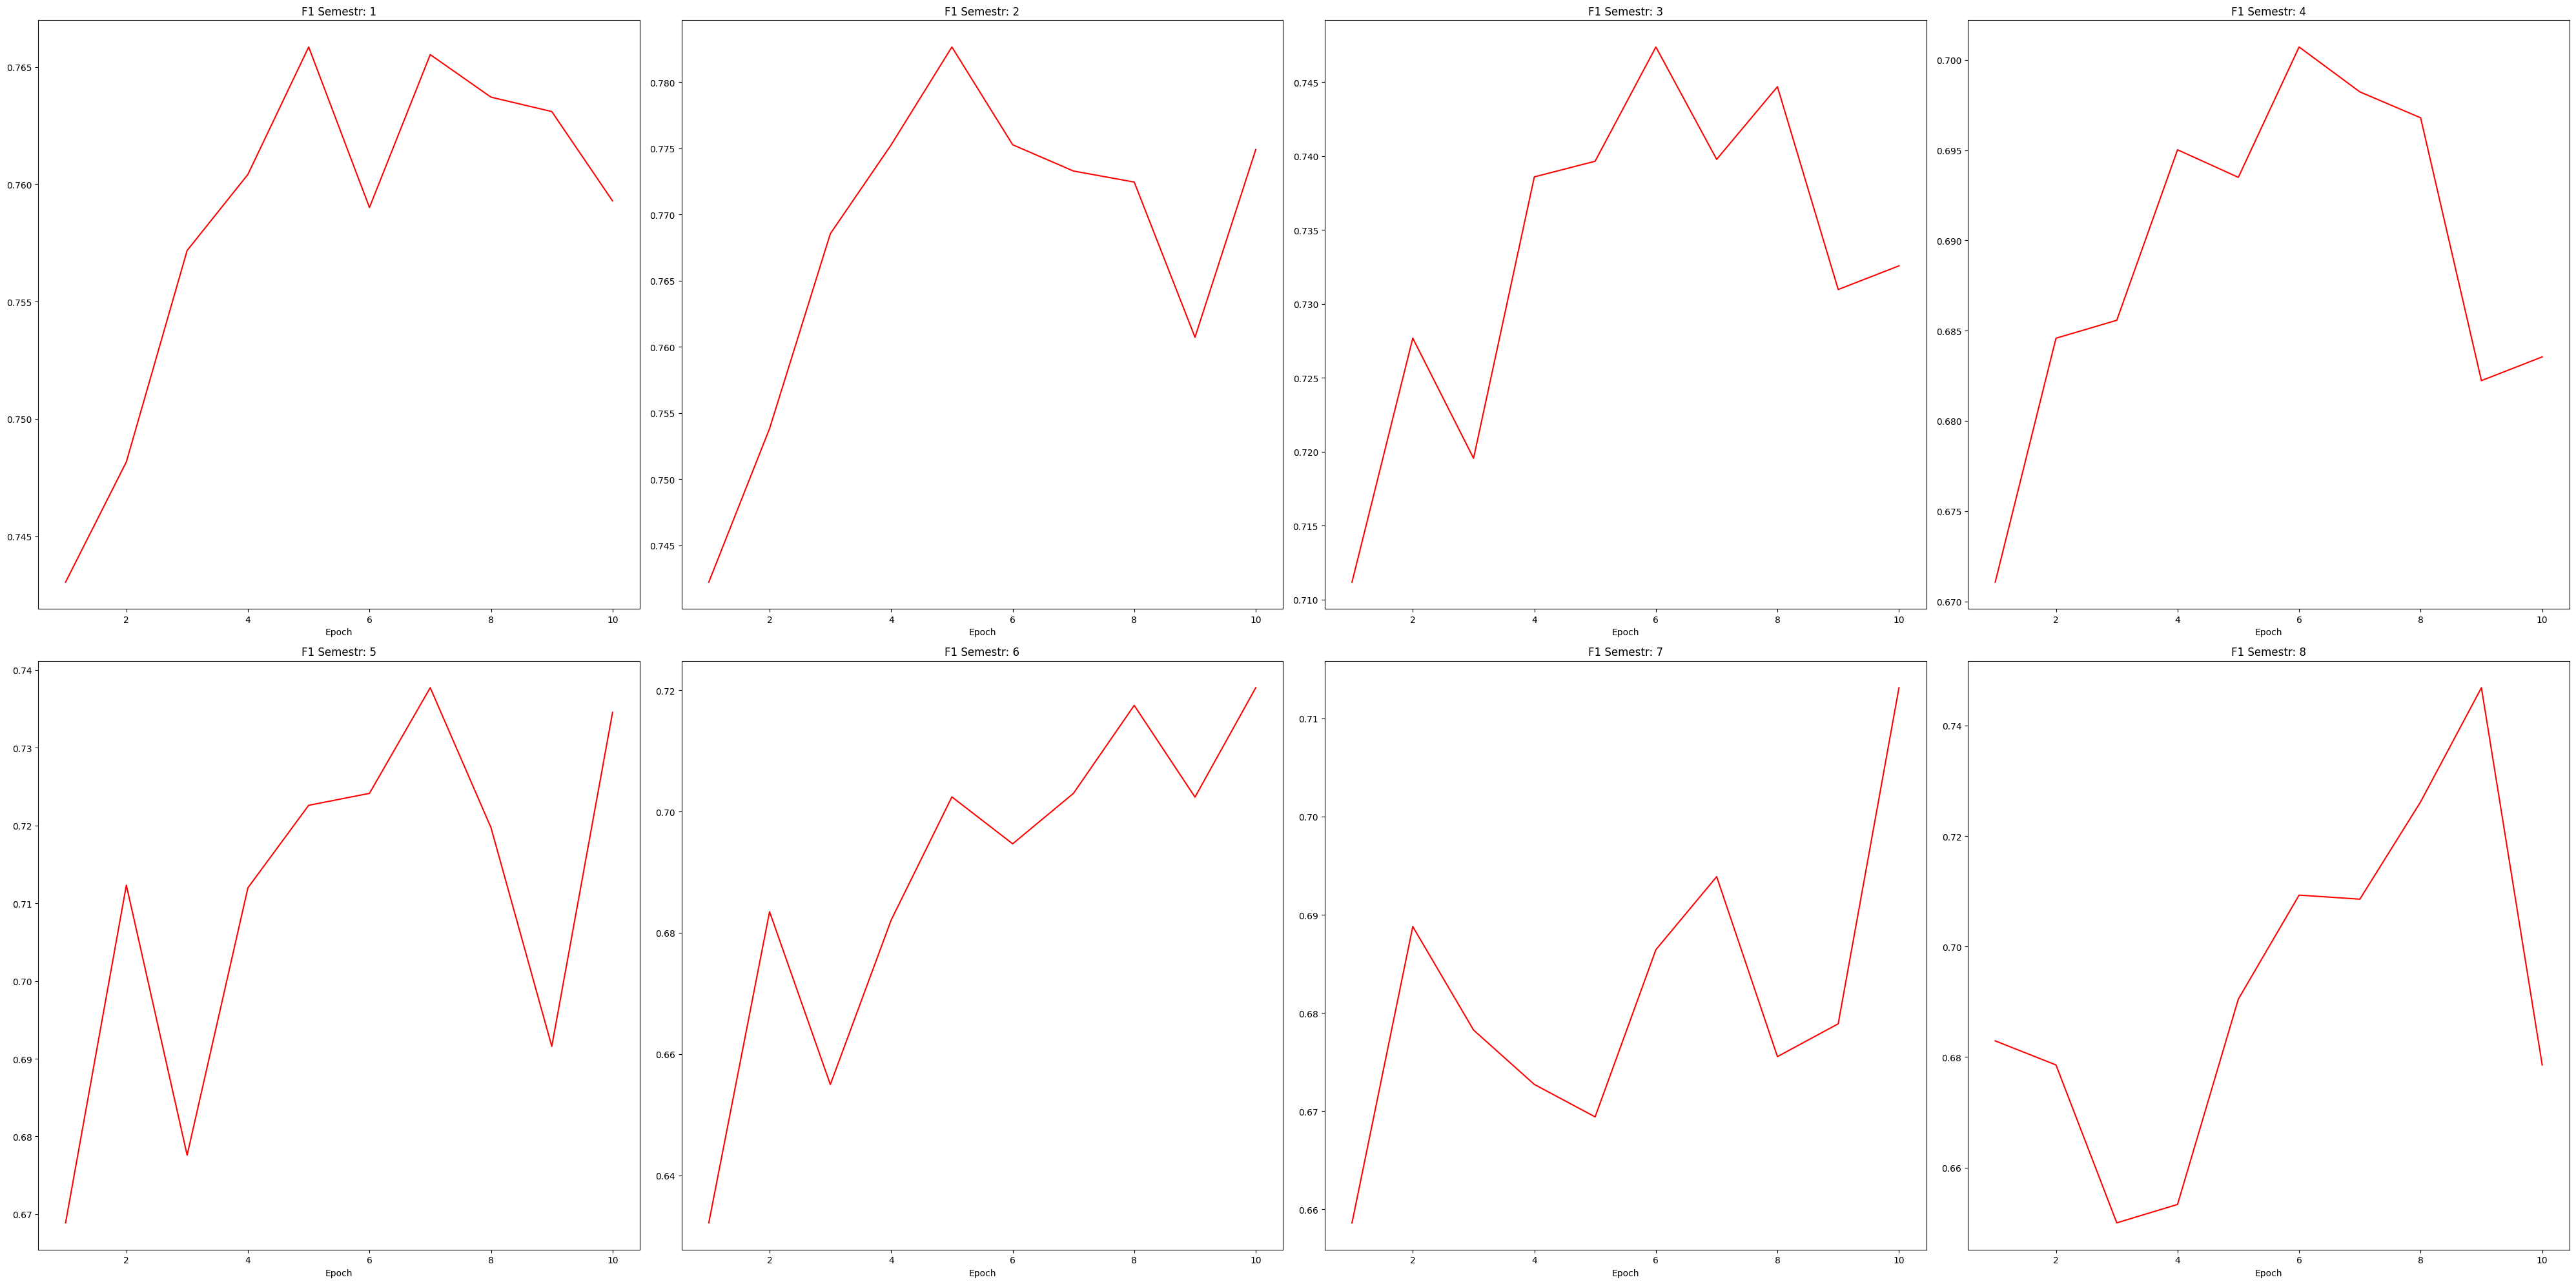

In [29]:
model_gru = OtchislenieModel_GRU(hidden_dim=128, input_size=max_len_data, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_gru.parameters())

model_gru = train_model(model_gru, optimizer, criterion, num_epoch=10)

Min Loss = 0.4584306624639843
Curr F1 = [0.64345616 0.68185213 0.65623043 0.5929368  0.65583456 0.61244019
 0.62857143 0.60204082]
Max F1 = [0.74079583 0.75452436 0.71659325 0.65005417 0.68562401 0.63938619
 0.70848708 0.66666667]
Curr AUC_ROC = [0.54678345 0.70623192 0.76017387 0.75428503 0.8063586  0.78543602
 0.81684369 0.82878757]
Max AUC_ROC = [0.75668372 0.79398223 0.79749434 0.77642827 0.8112426  0.78890609
 0.85354039 0.86654128]
Семестр 1
              precision    recall  f1-score   support

         0.0       0.82      0.63      0.71      1555
         1.0       0.65      0.84      0.73      1299

    accuracy                           0.72      2854
   macro avg       0.74      0.73      0.72      2854
weighted avg       0.74      0.72      0.72      2854

Семестр 2
              precision    recall  f1-score   support

         0.0       0.85      0.79      0.82      1555
         1.0       0.71      0.80      0.75      1036

    accuracy                           0.79    

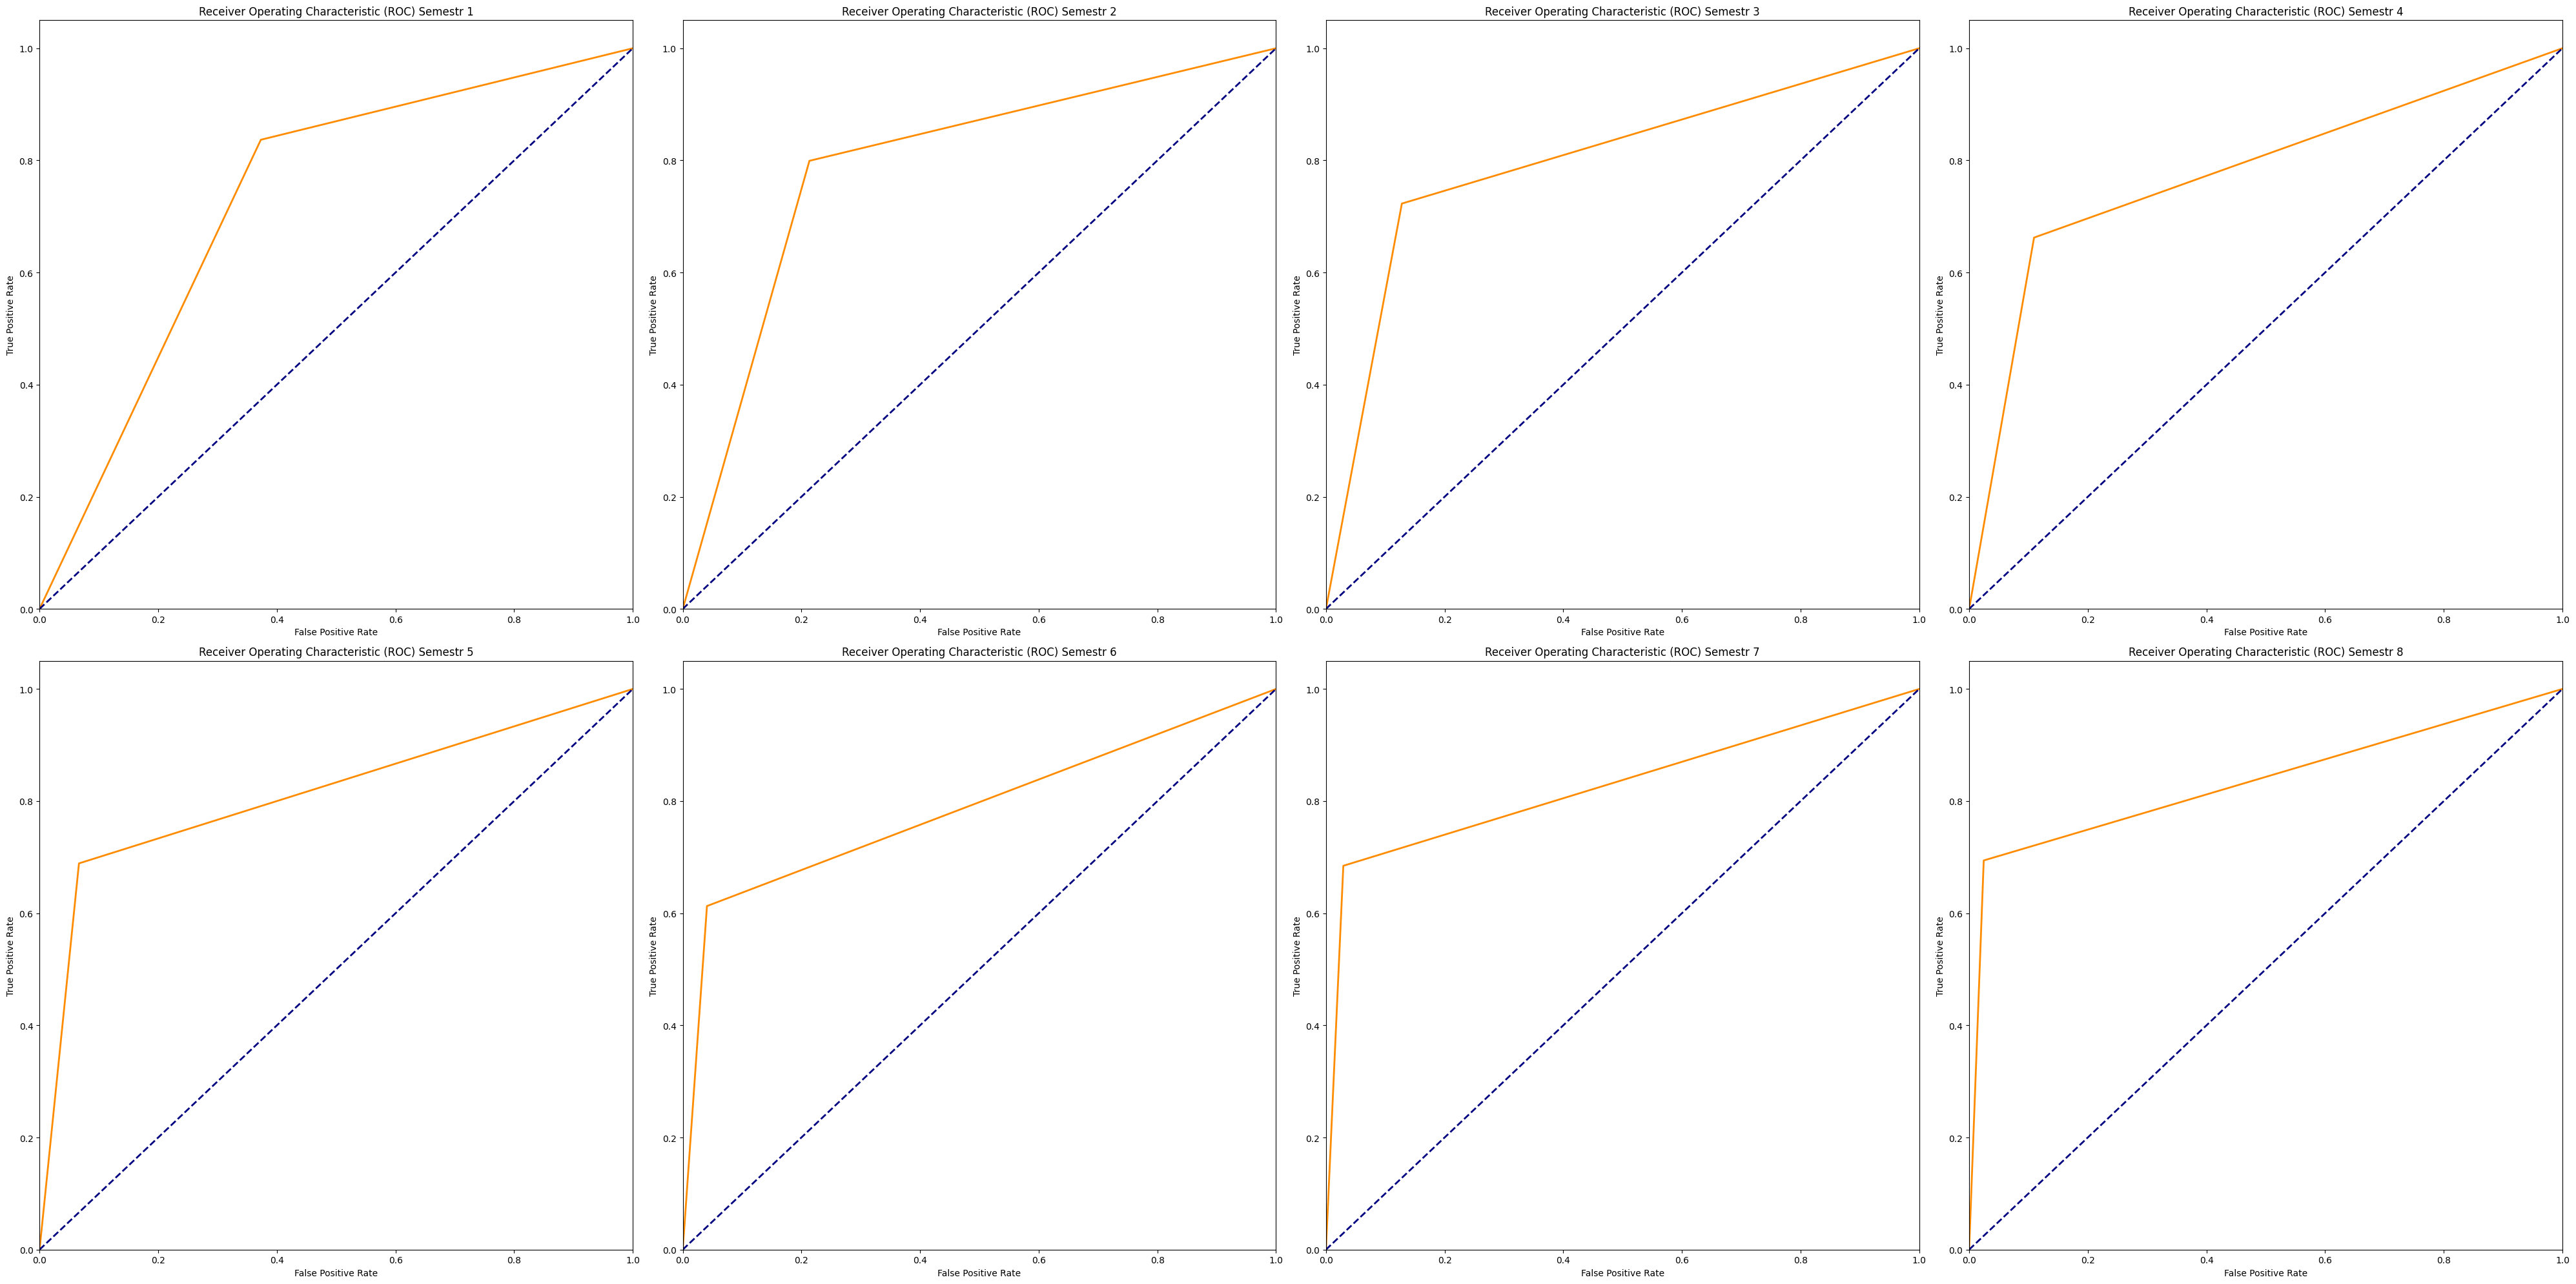

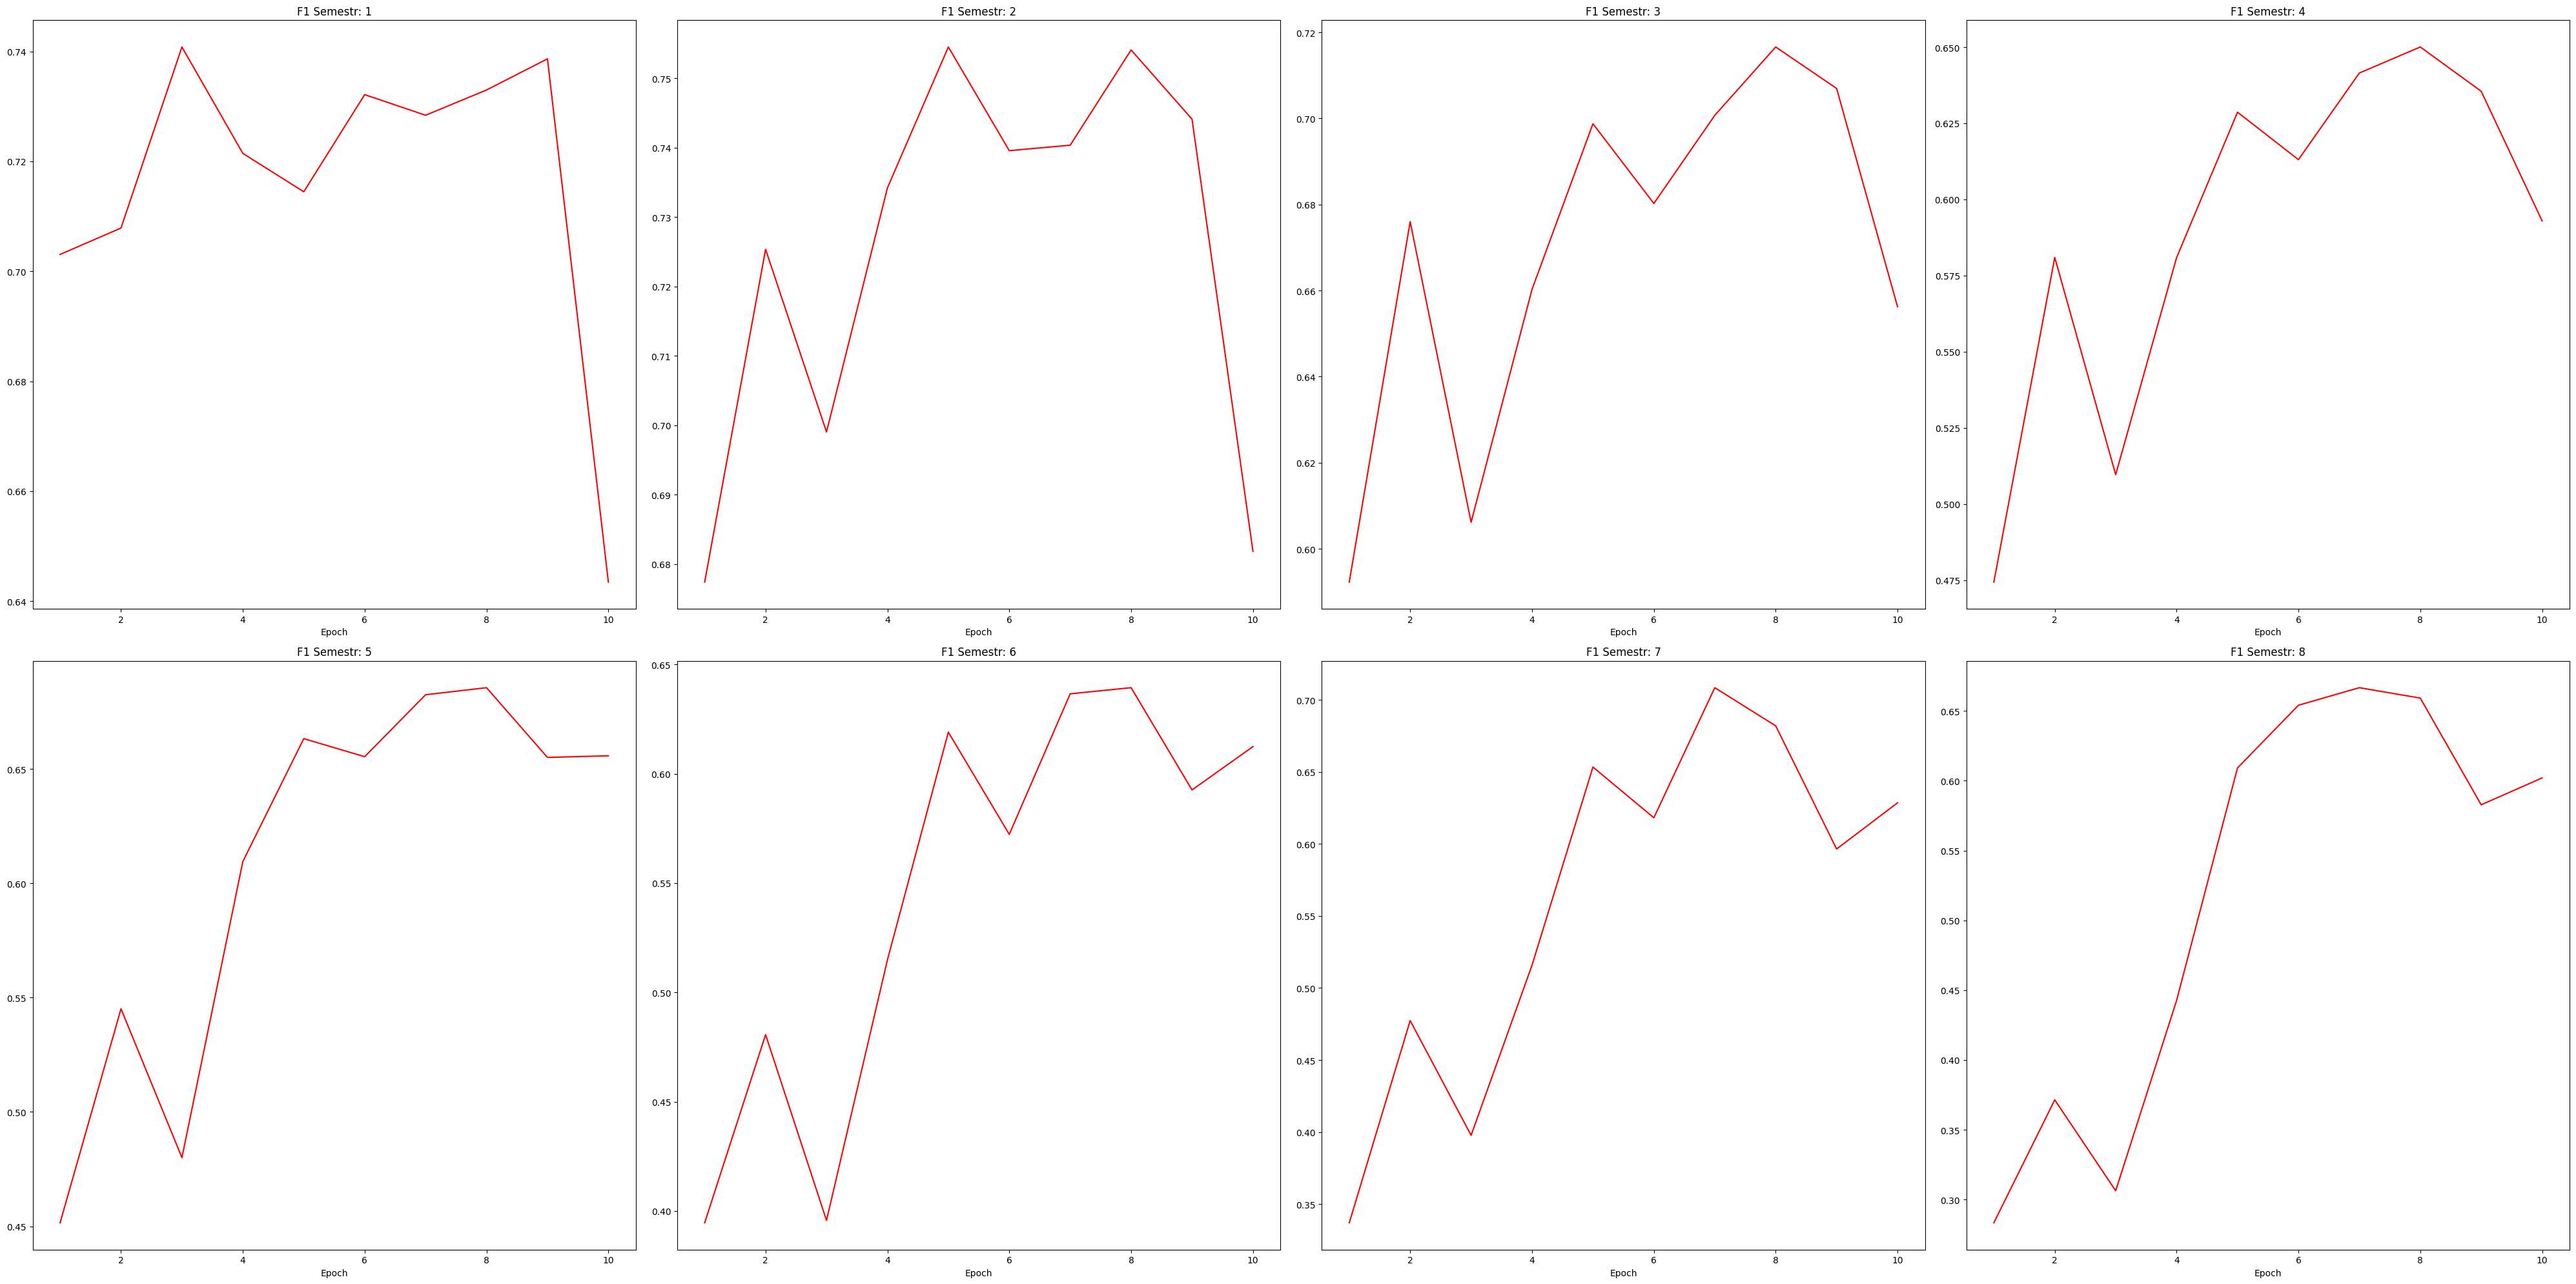

In [30]:
model_gru = OtchislenieModel_GRU(hidden_dim=512, input_size=max_len_data, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_gru.parameters())

model_gru = train_model(model_gru, optimizer, criterion, num_epoch=10)

LSTM Base Structure

Min Loss = 0.4589742972222272
Curr F1 = [0.728      0.72026801 0.62235067 0.54324734 0.5258427  0.42105263
 0.4047619  0.29411765]
Max F1 = [0.74343289 0.75338189 0.70480929 0.65720081 0.69073783 0.63215259
 0.67132867 0.68235294]
Curr AUC_ROC = [0.75670031 0.77592366 0.72639752 0.68888449 0.68144078 0.63528122
 0.62937453 0.58753255]
Max AUC_ROC = [0.75670031 0.79733082 0.79111111 0.79037008 0.81720672 0.79264061
 0.84831027 0.85609111]
Семестр 1
              precision    recall  f1-score   support

         0.0       0.77      0.78      0.77      1555
         1.0       0.73      0.72      0.72      1299

    accuracy                           0.75      2854
   macro avg       0.75      0.75      0.75      2854
weighted avg       0.75      0.75      0.75      2854

Семестр 2
              precision    recall  f1-score   support

         0.0       0.82      0.83      0.83      1555
         1.0       0.75      0.73      0.74      1036

    accuracy                           0.79    

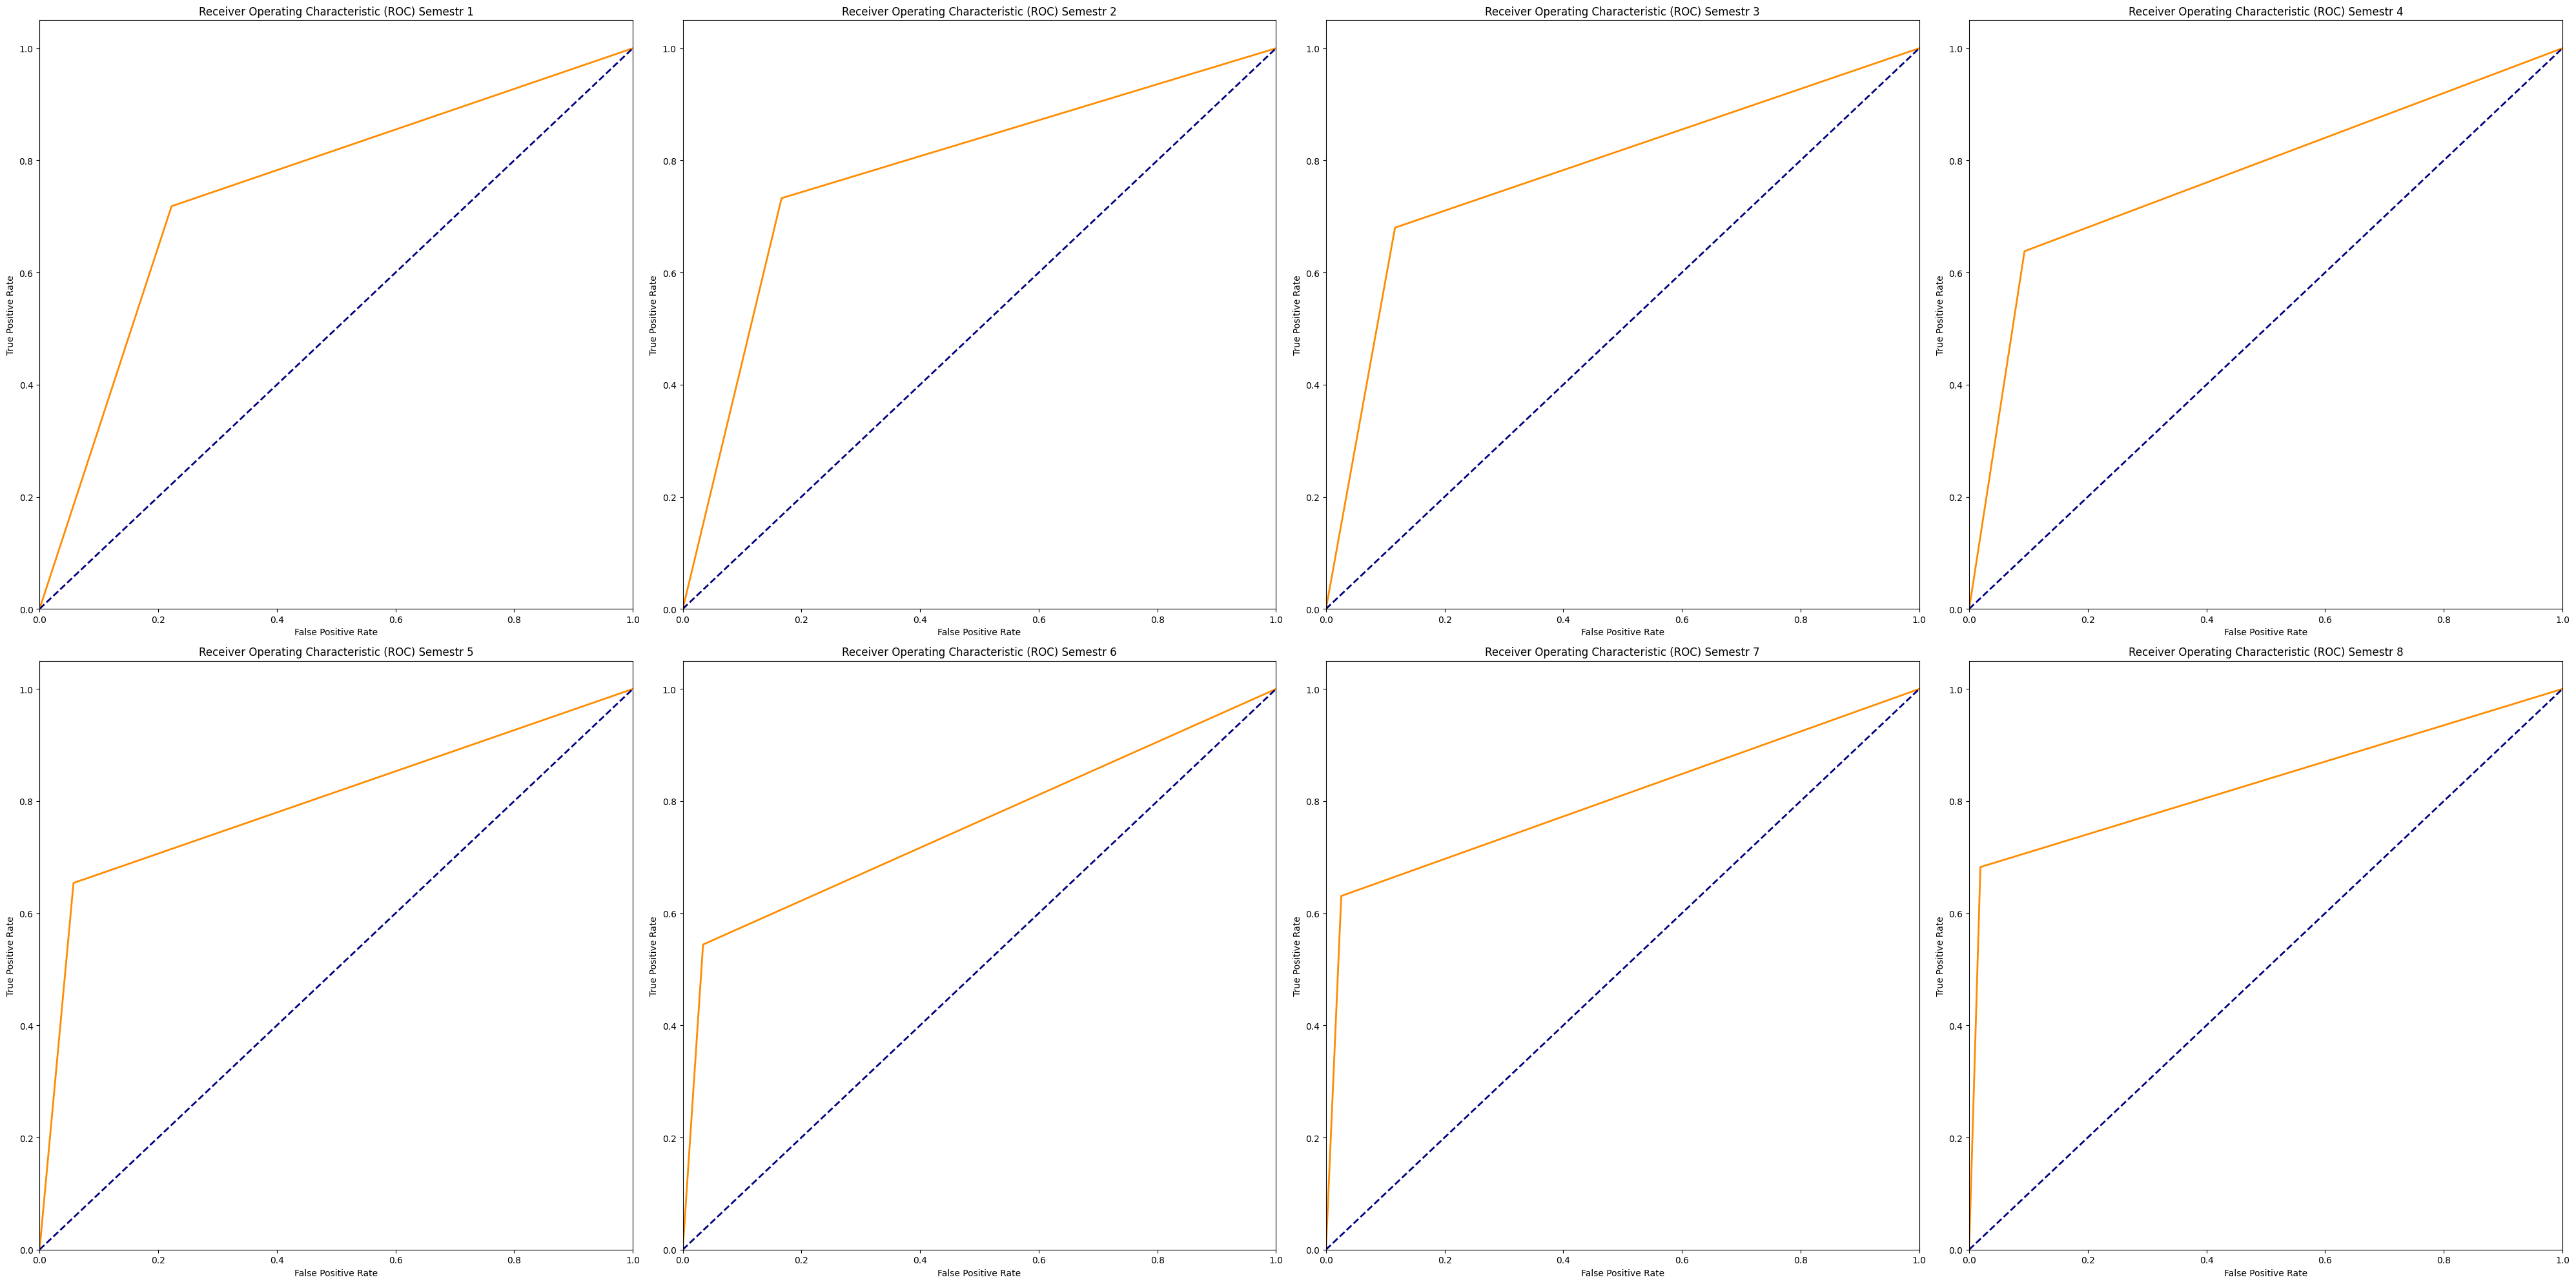

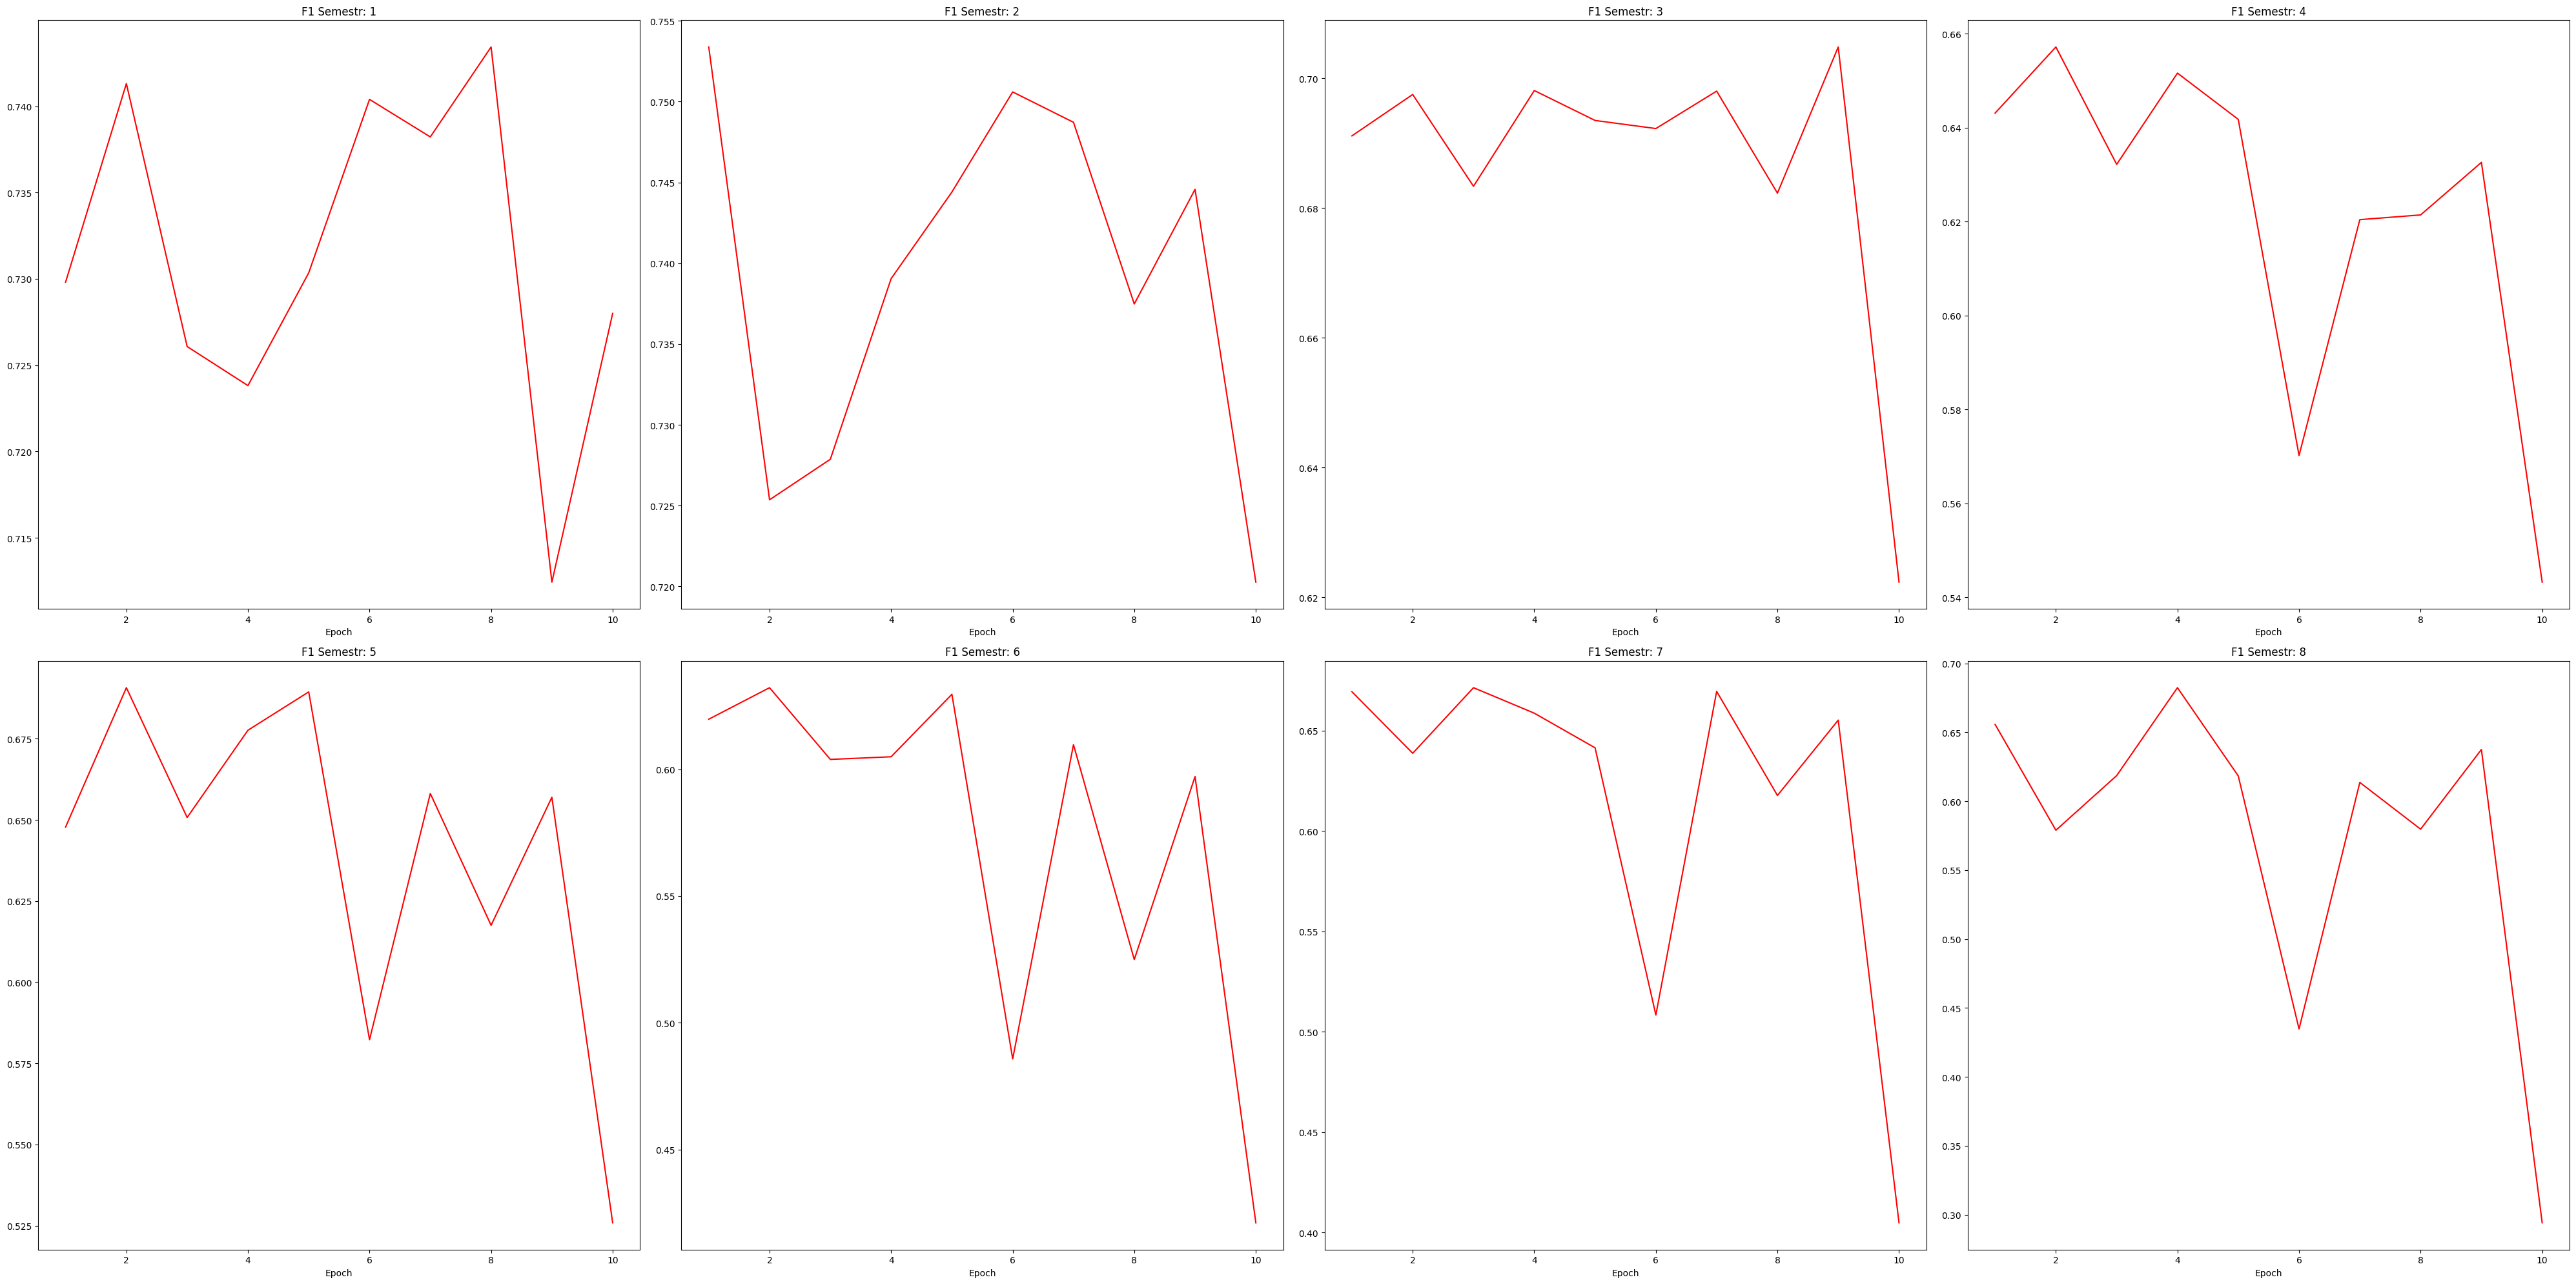

In [31]:
model_lstm = OtchislenieModel_LSTM(hidden_dim=256, input_size=max_len_data, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_lstm.parameters())

model_lstm = train_model(model_lstm, optimizer, criterion, num_epoch=10)

Min Loss = 0.40542772585933756
Curr F1 = [0.75876727 0.78244455 0.72982976 0.69644903 0.73333333 0.72727273
 0.74285714 0.73255814]
Max F1 = [0.76526858 0.78244455 0.74440895 0.71394799 0.73333333 0.72727273
 0.74285714 0.73825503]
Curr AUC_ROC = [0.76658102 0.8184245  0.80634274 0.7982178  0.82783883 0.82965041
 0.8416318  0.86215535]
Max AUC_ROC = [0.77844298 0.8184245  0.81499107 0.80405405 0.82783883 0.82965041
 0.8416318  0.86215535]
Семестр 1
              precision    recall  f1-score   support

         0.0       0.82      0.75      0.78      1555
         1.0       0.73      0.80      0.76      1299

    accuracy                           0.77      2854
   macro avg       0.77      0.77      0.77      2854
weighted avg       0.78      0.77      0.77      2854

Семестр 2
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85      1555
         1.0       0.77      0.78      0.77      1036

    accuracy                           0.82   

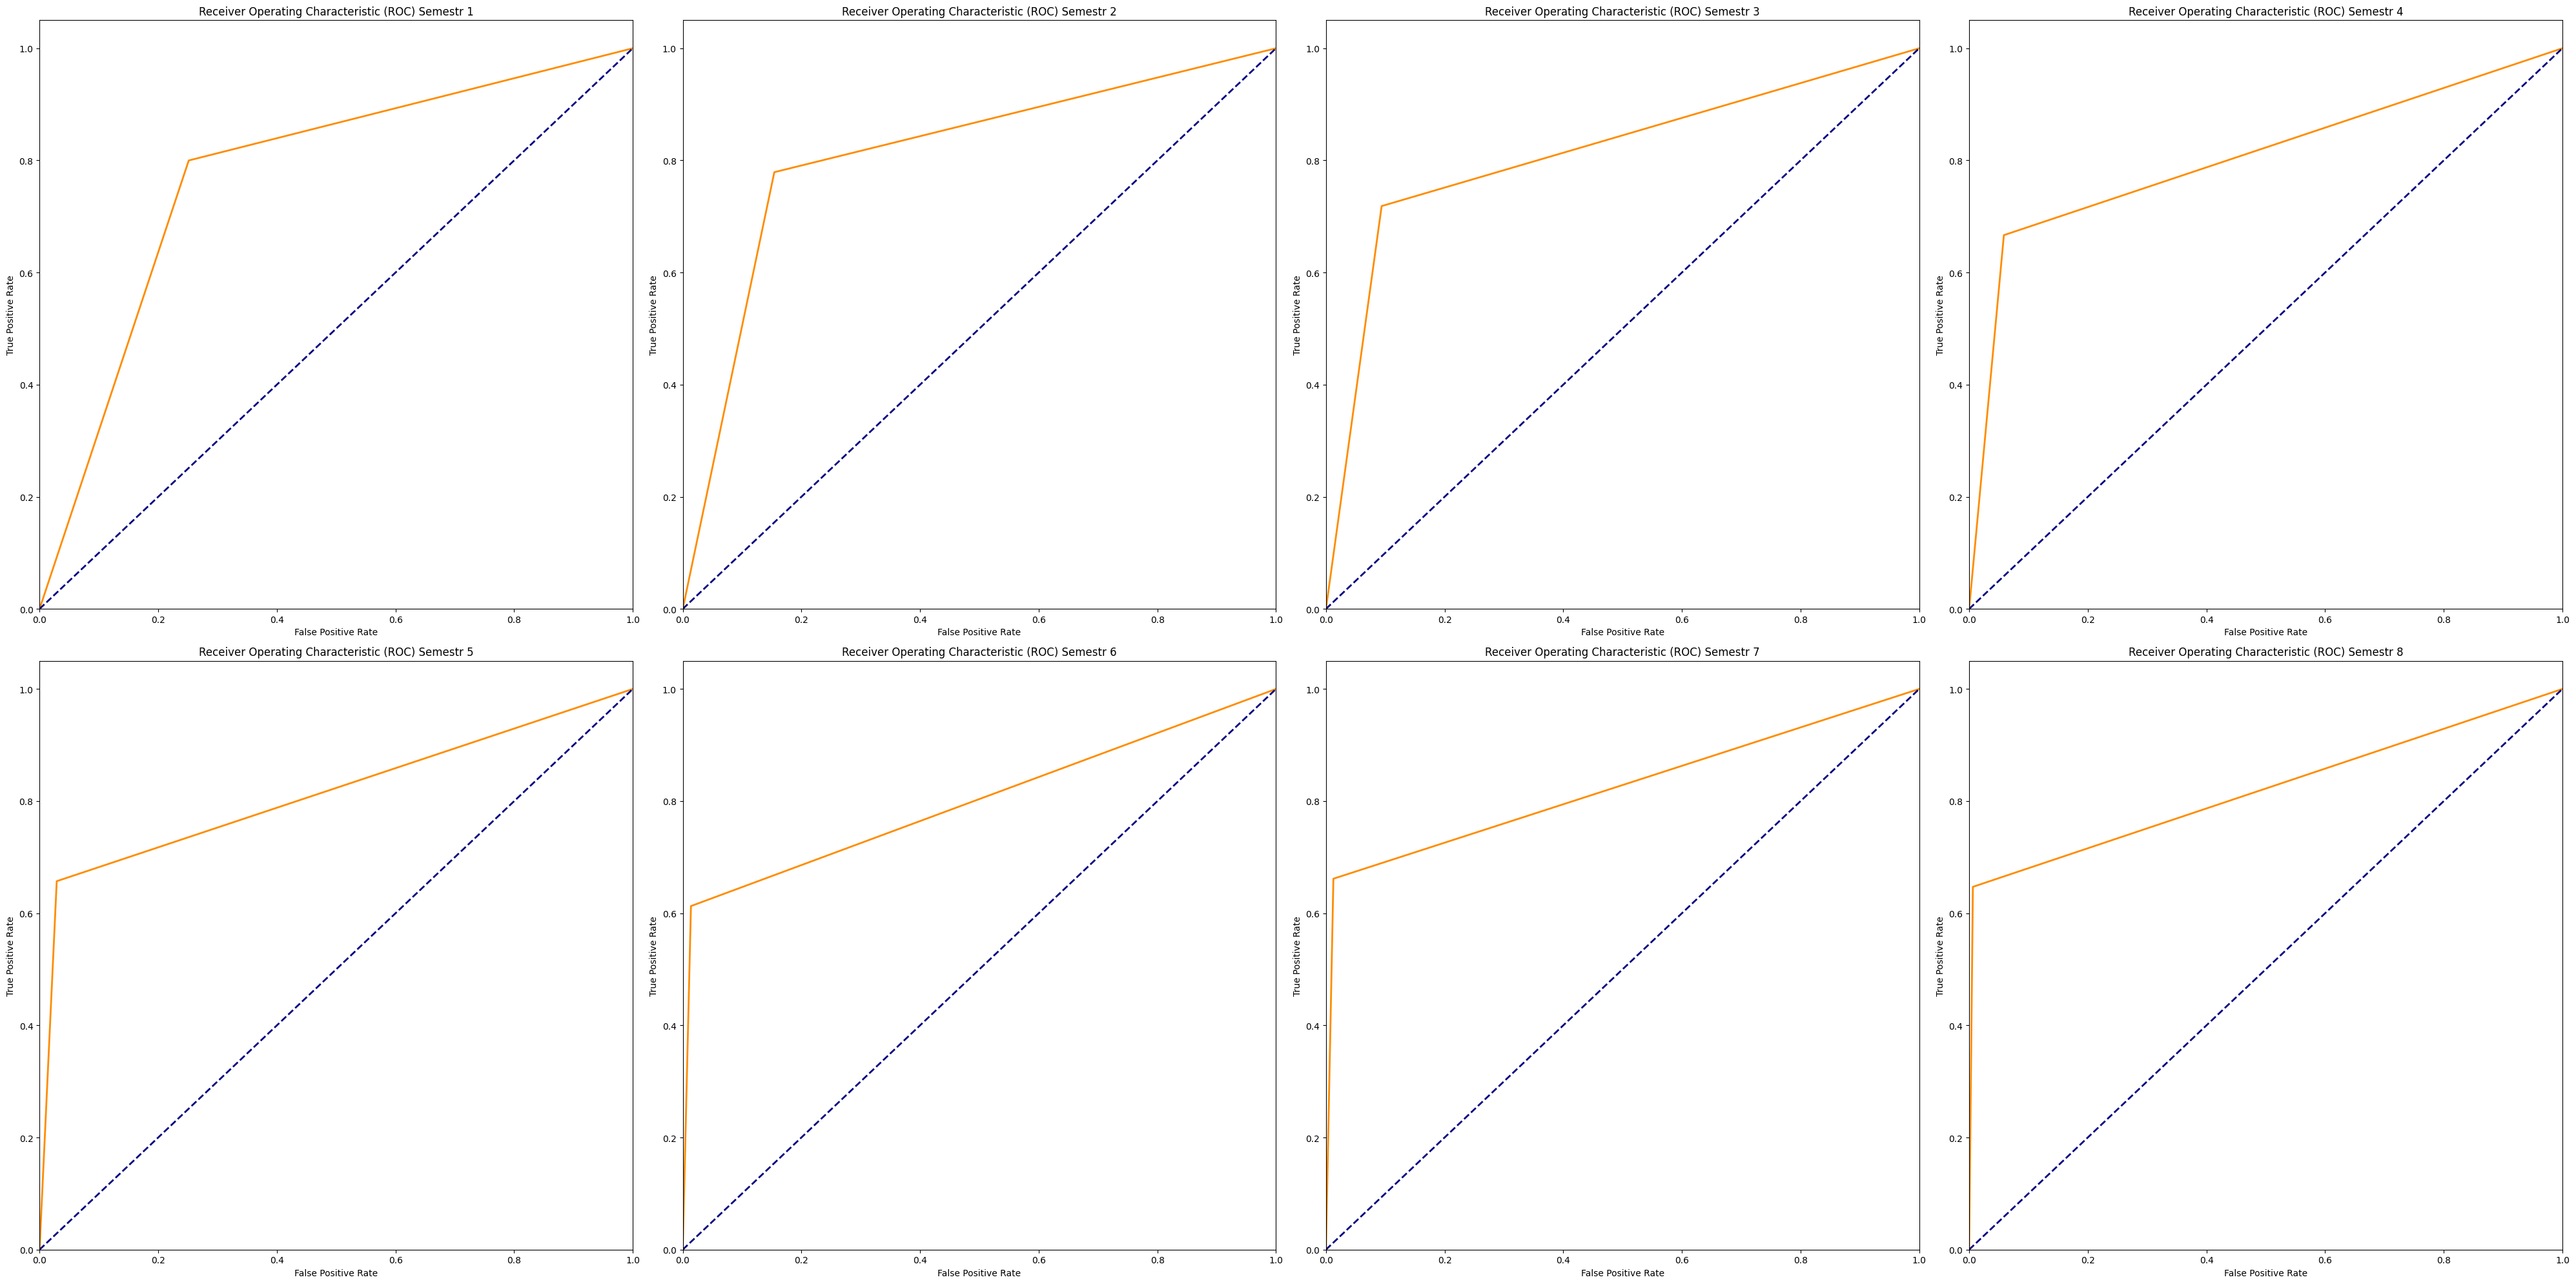

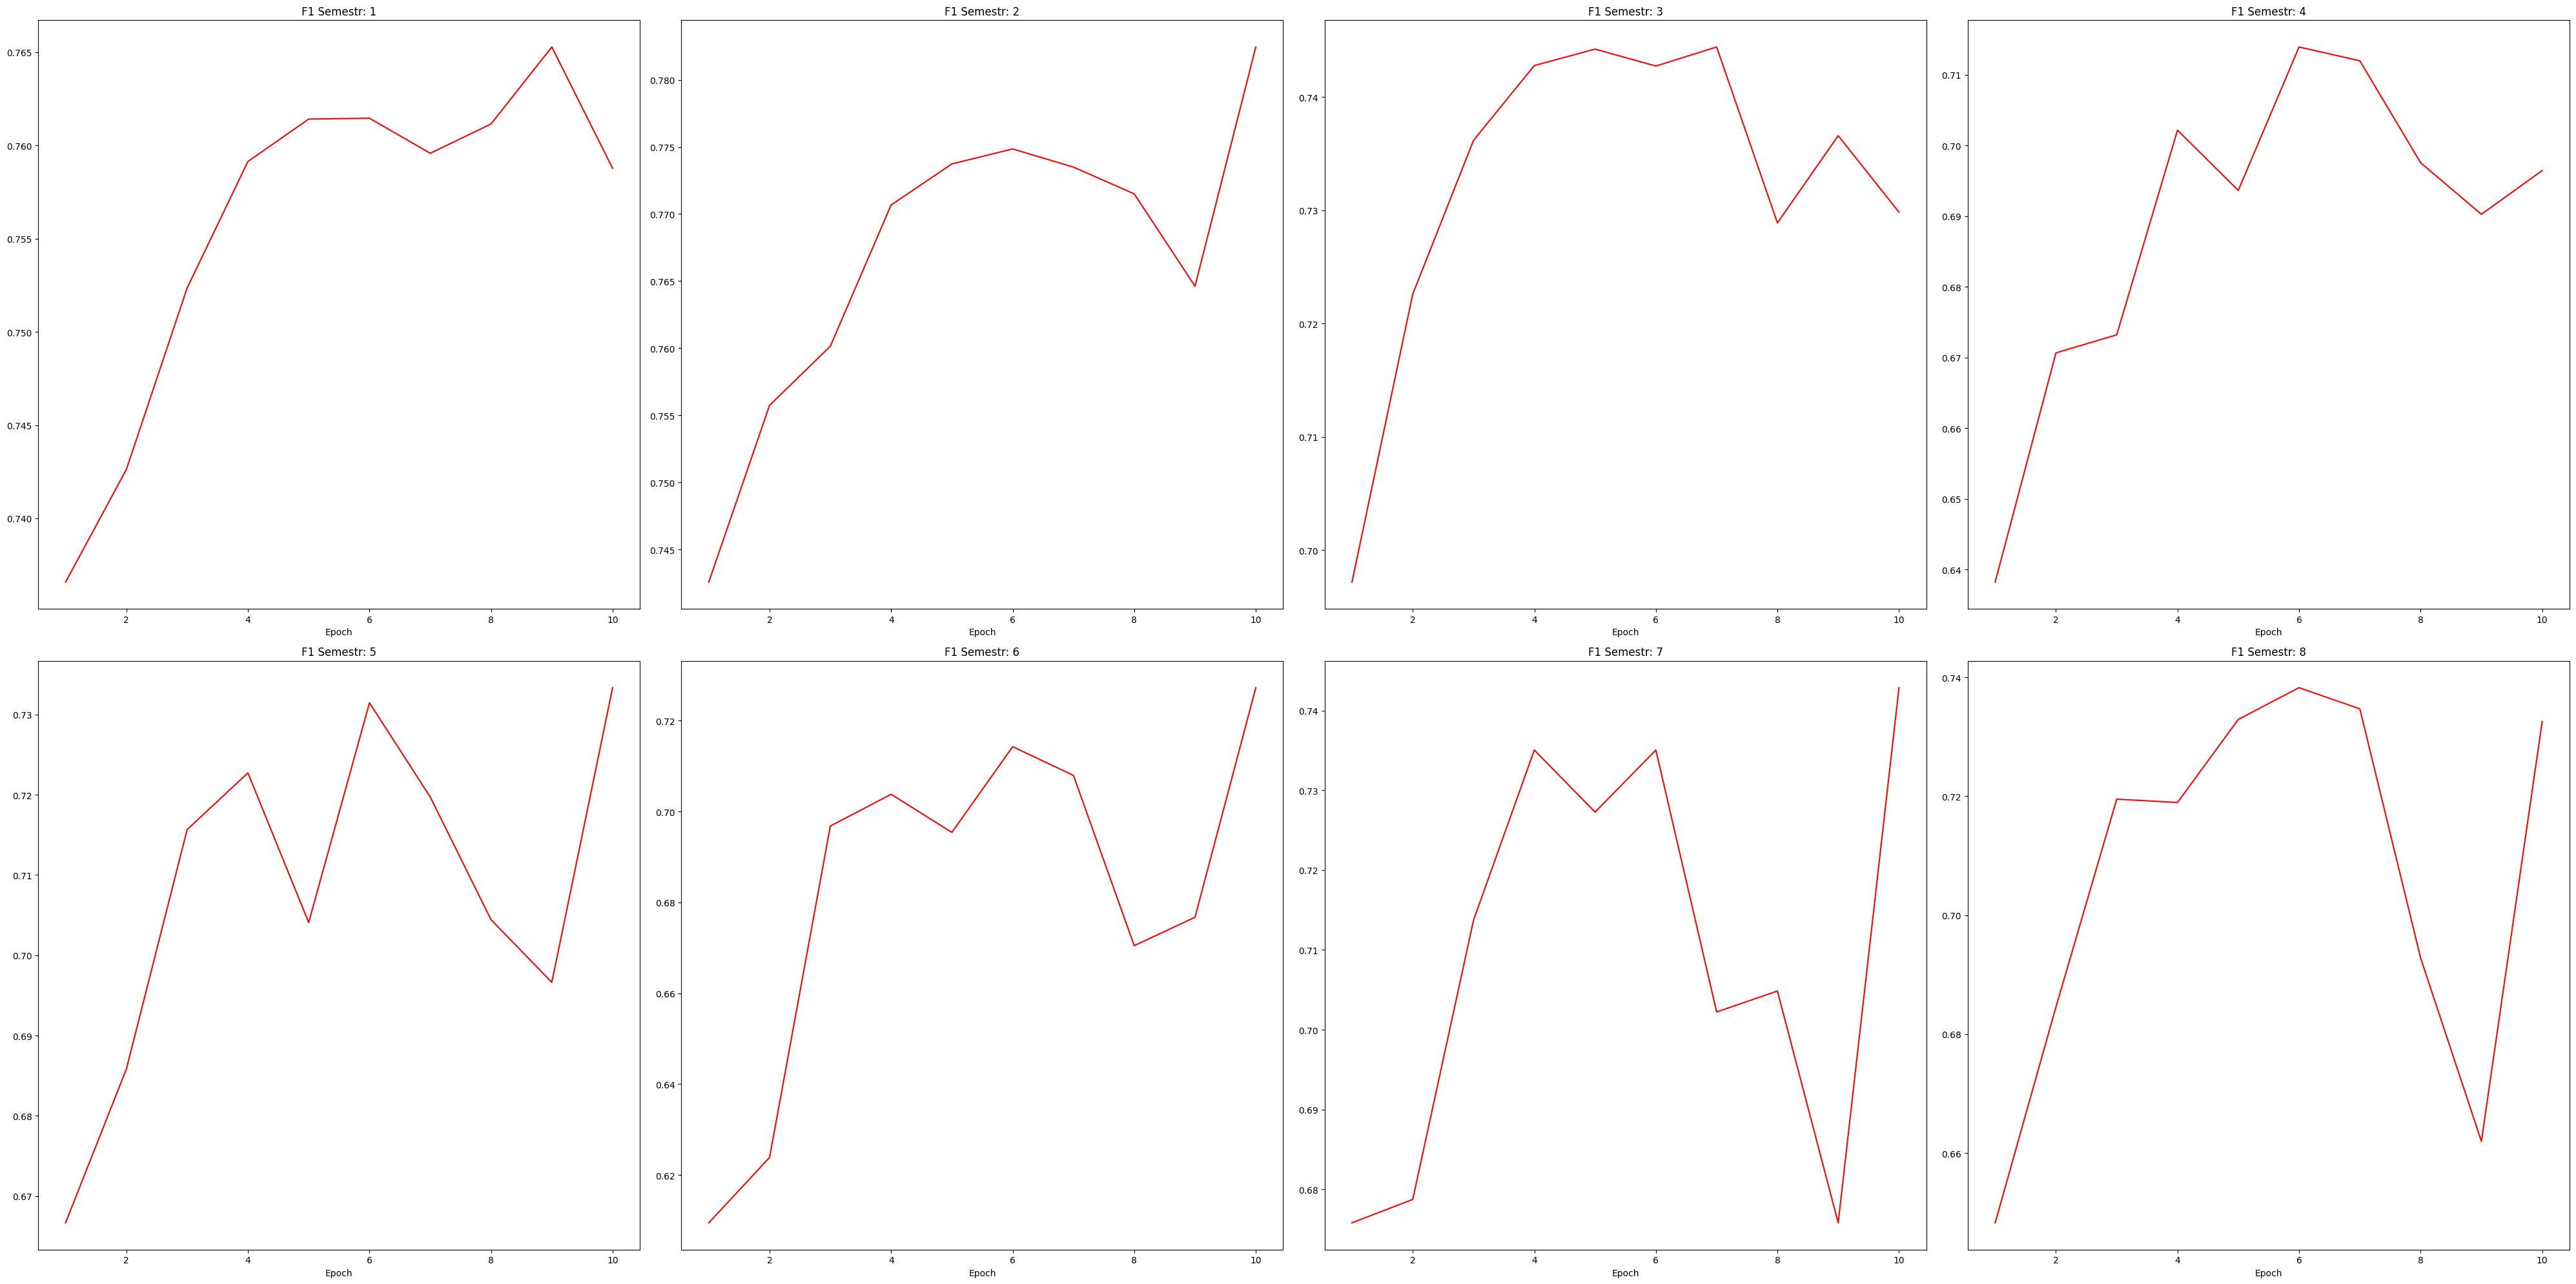

In [32]:
model_lstm = OtchislenieModel_LSTM(hidden_dim=128, input_size=max_len_data, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_lstm.parameters())

model_lstm = train_model(model_lstm, optimizer, criterion, num_epoch=10)

Min Loss = 0.5065827505907495
Curr F1 = [0.72439863 0.71177686 0.59944496 0.48318043 0.44444444 0.29268293
 0.22666667 0.02272727]
Max F1 = [0.72439863 0.71189979 0.66408068 0.60606061 0.60883797 0.56476684
 0.59636364 0.54347826]
Curr AUC_ROC = [0.72659701 0.7646833  0.71363344 0.66055767 0.64460411 0.58626161
 0.56433859 0.50517961]
Max AUC_ROC = [0.73293431 0.76548498 0.75722996 0.74395919 0.76875176 0.76202915
 0.79341809 0.7769005 ]
Семестр 1
              precision    recall  f1-score   support

         0.0       0.73      0.81      0.77      1555
         1.0       0.74      0.65      0.69      1299

    accuracy                           0.74      2854
   macro avg       0.74      0.73      0.73      2854
weighted avg       0.74      0.74      0.73      2854

Семестр 2
              precision    recall  f1-score   support

         0.0       0.79      0.87      0.83      1555
         1.0       0.78      0.66      0.71      1036

    accuracy                           0.79    

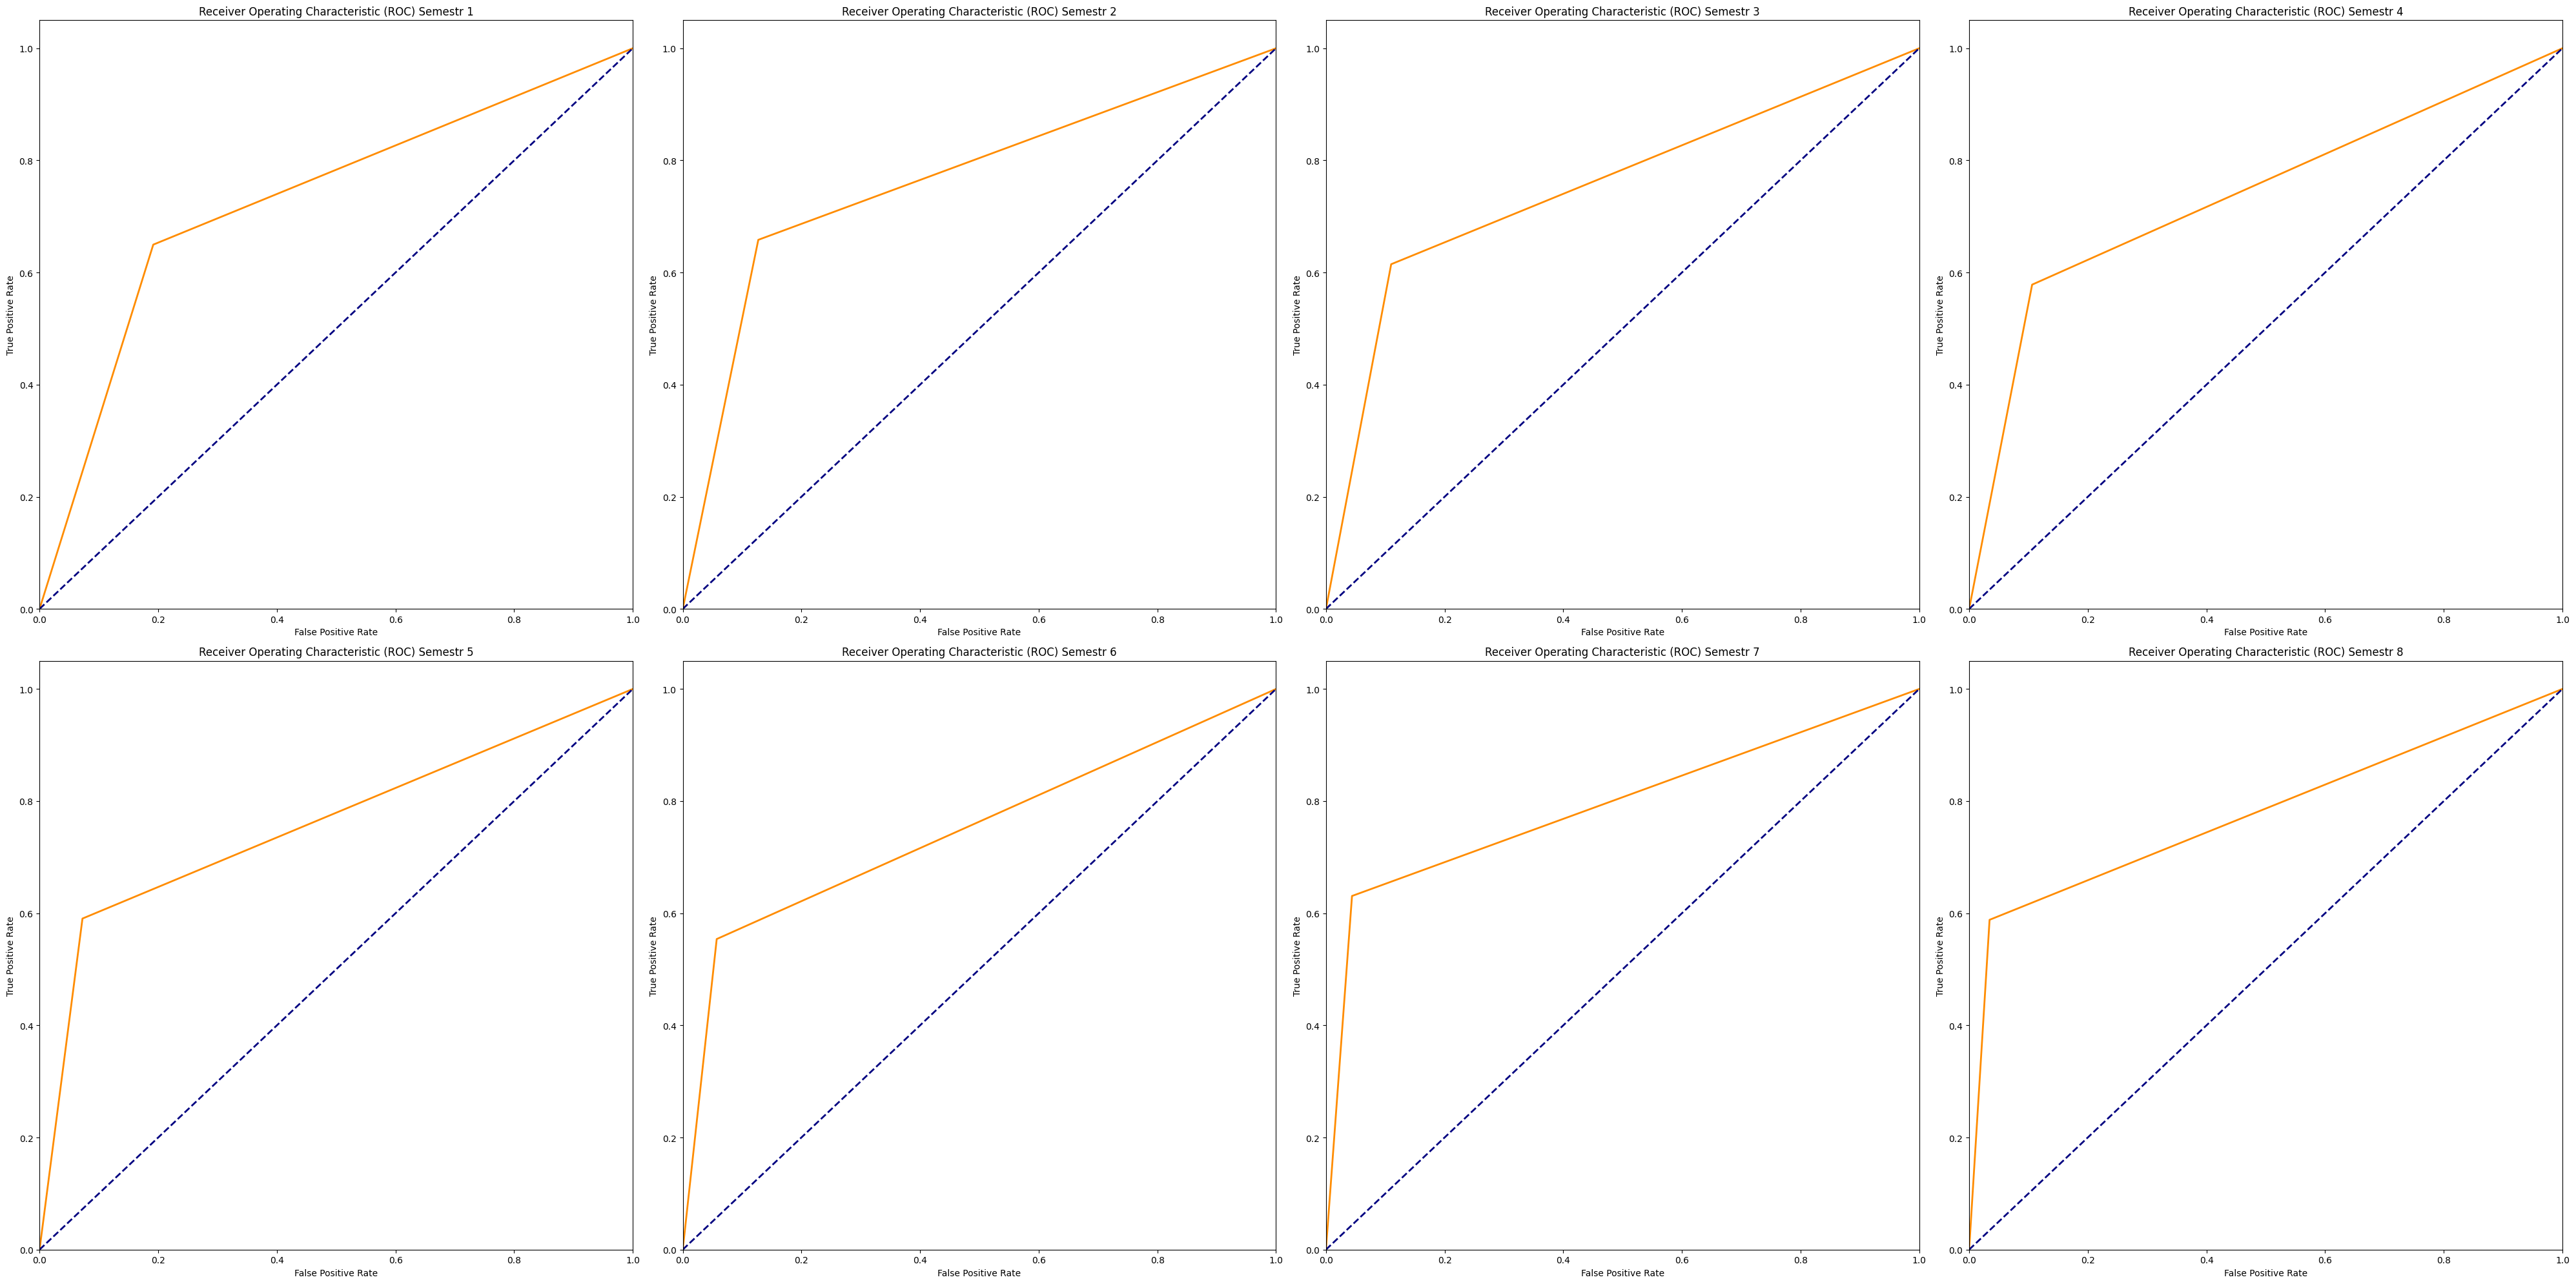

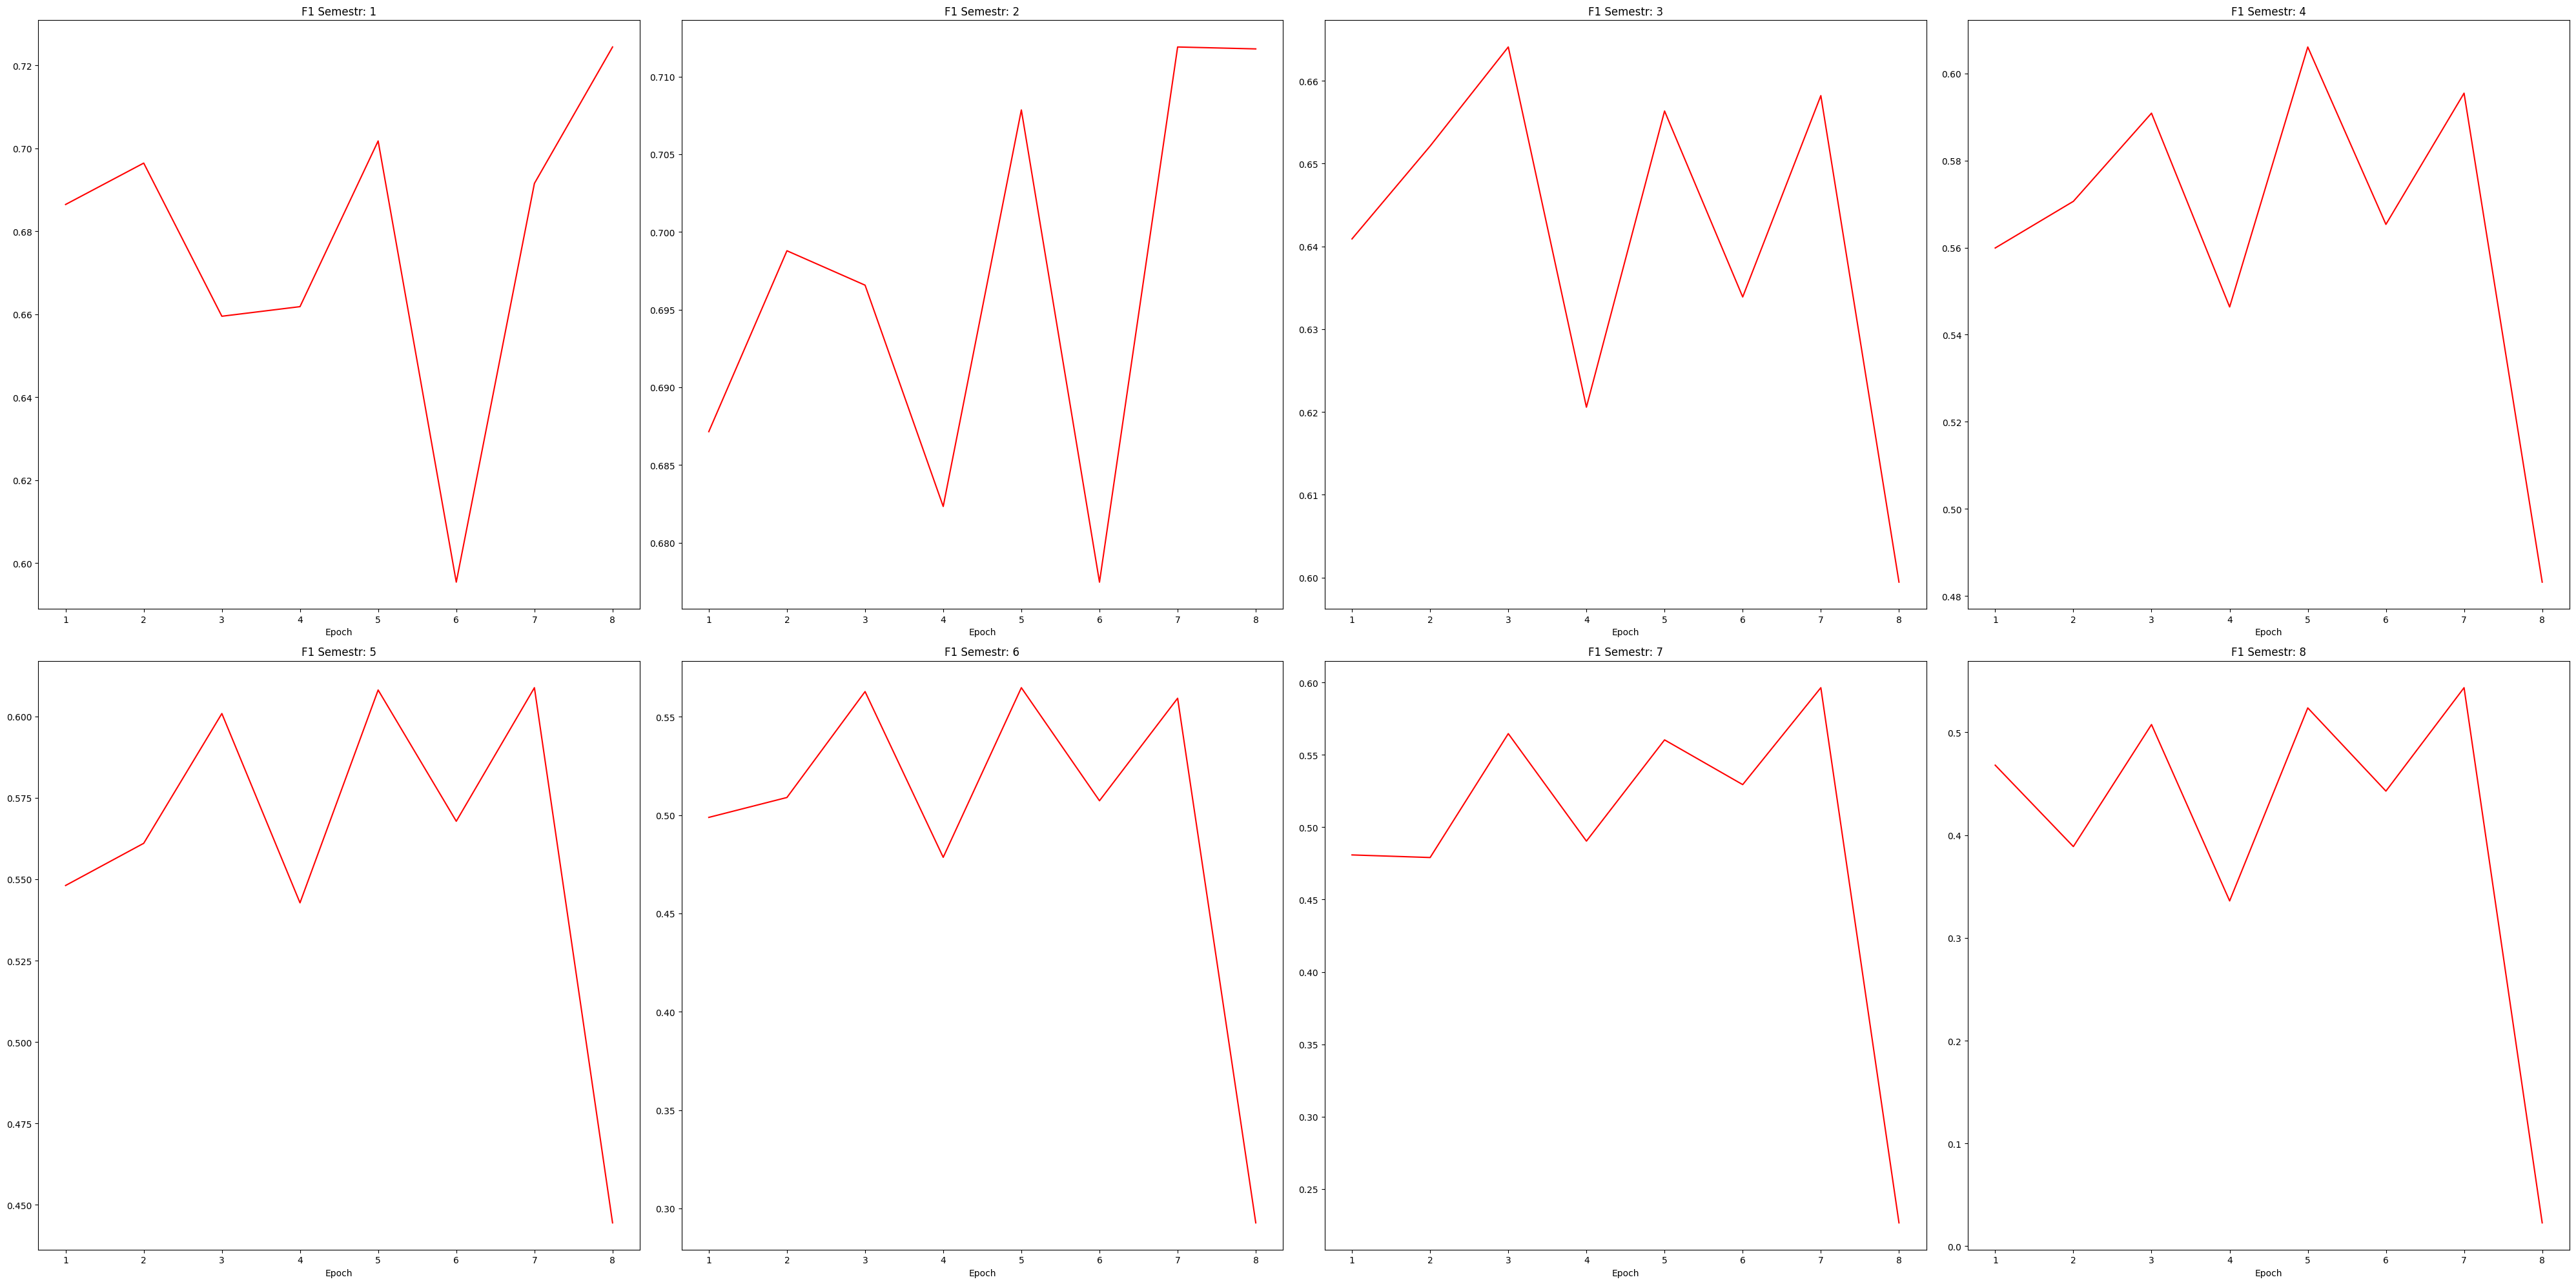

Training epoch 9:   0%|          | 0/11414 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [33]:
model_lstm = OtchislenieModel_LSTM(hidden_dim=512, input_size=max_len_data, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_lstm.parameters())

model_lstm = train_model(model_lstm, optimizer, criterion, num_epoch=10)

Vanilla RNN Custom Structure

              precision    recall  f1-score   support

         0.0       0.78      0.89      0.83      1247
         1.0       0.90      0.80      0.85      1601

    accuracy                           0.84      2848
   macro avg       0.84      0.85      0.84      2848
weighted avg       0.85      0.84      0.84      2848



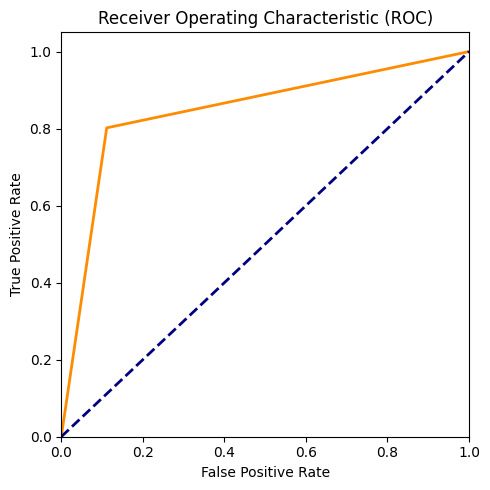

Min Loss = 0.40857301010730857, Curr F1 = 0.8487229862475443, Max F1 = 0.8492063492063492, Curr AUC_ROC = 0.841795950506074, Max AUC_ROC = 0.8452656143639176


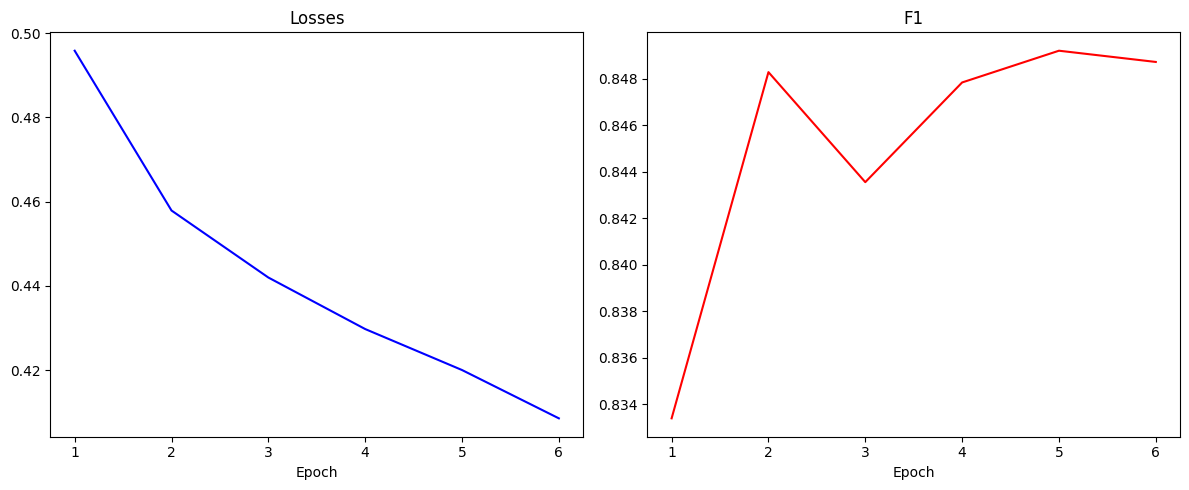

Training epoch 7:   0%|          | 0/11392 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model_rnn_custom = OtchislenieModel_CustomStructure(input_size=max_len_data, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_rnn_custom.parameters())

model_rnn_custom = train_model(model_rnn_custom, optimizer, criterion, num_epoch=10)

GRU Custom Structure

              precision    recall  f1-score   support

         0.0       0.73      0.94      0.83      1243
         1.0       0.94      0.74      0.83      1605

    accuracy                           0.83      2848
   macro avg       0.84      0.84      0.83      2848
weighted avg       0.85      0.83      0.83      2848



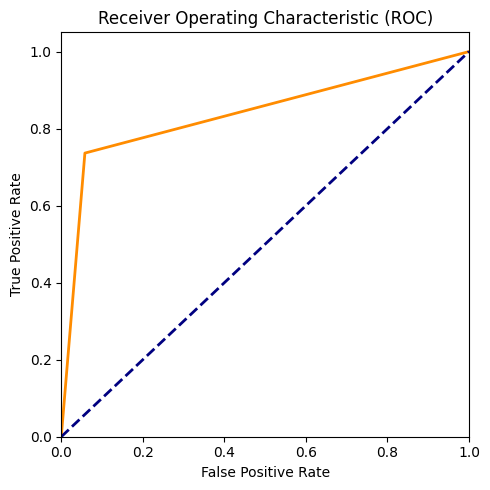

Min Loss = 0.3228619225620309, Curr F1 = 0.826027397260274, Max F1 = 0.8268625393494228, Curr AUC_ROC = 0.8318553995834618, Max AUC_ROC = 0.839262110811197


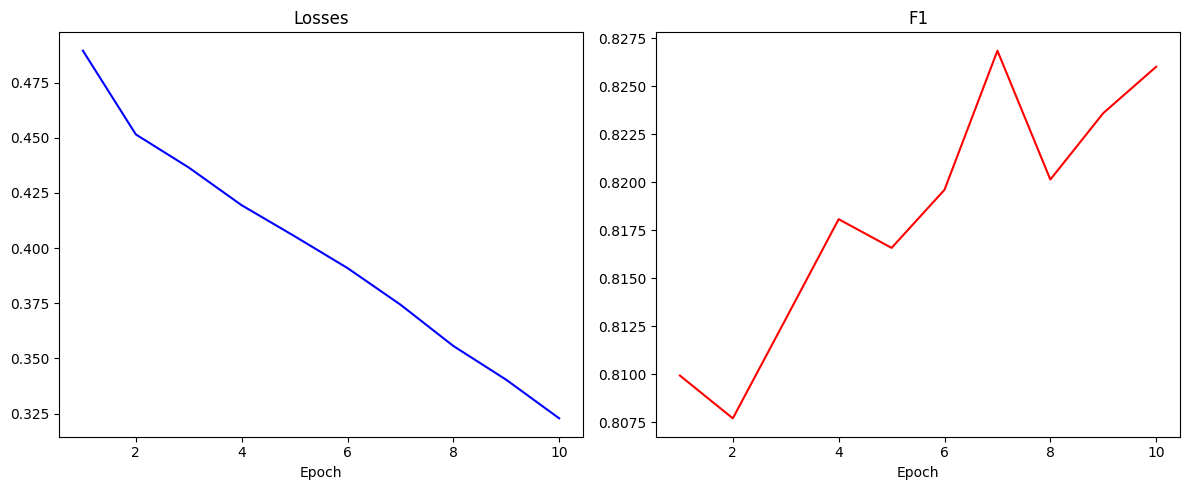

In [ ]:
model_gru_custom = OtchislenieModel_GRU_CustomStructure(input_size=max_len_data, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_gru_custom.parameters())

model_gru_custom = train_model(model_gru_custom, optimizer, criterion, num_epoch=10)

LSTM Custom Structure

              precision    recall  f1-score   support

         0.0       0.75      0.92      0.82      1243
         1.0       0.92      0.76      0.83      1605

    accuracy                           0.83      2848
   macro avg       0.83      0.84      0.83      2848
weighted avg       0.84      0.83      0.83      2848



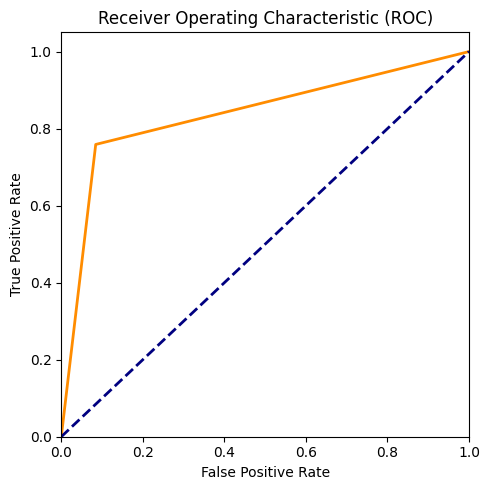

Min Loss = 0.2537123254775416, Curr F1 = 0.831967213114754, Max F1 = 0.831967213114754, Curr AUC_ROC = 0.8372027277990391, Max AUC_ROC = 0.8467595481738233


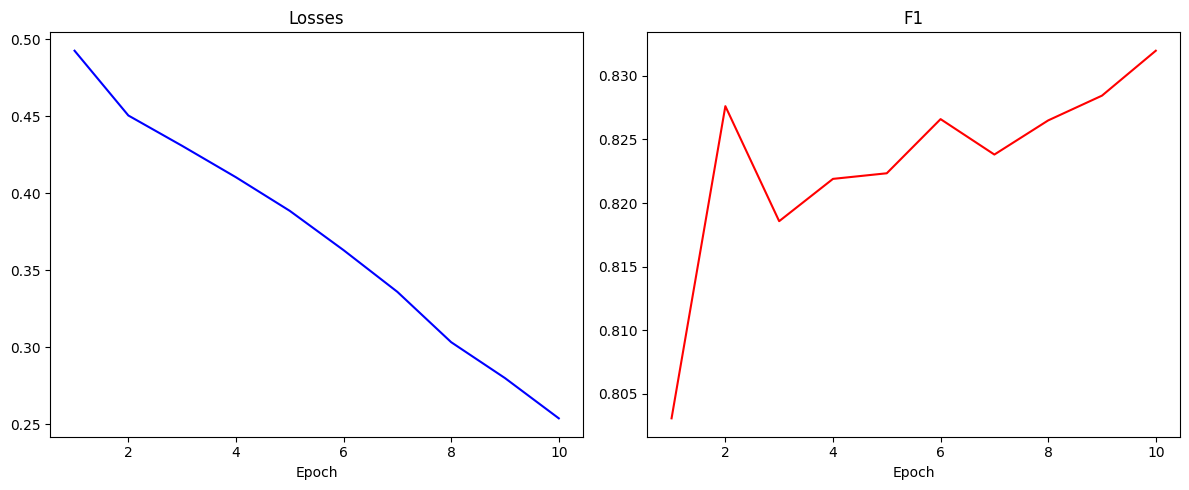

In [ ]:
model_lstm_custom = OtchislenieModel_LSTM_CustomStructure(input_size=max_len_data, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_lstm_custom.parameters())

model_lstm_custom = train_model(model_lstm_custom, optimizer, criterion, num_epoch=10)